# Training Notebook for OMR Assembly Model
This notebook trains the MLP model for music notation assembly using ground truth data.

## 1. Setup and Imports

In [1]:
import torch
import numpy as np
import yaml
import os
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from utils.data_pool_gt import load_ground_truth_data
from utils.constants import get_classlist_and_classdict
from utils.utility import set_seed
from configs.assembler.default import get_cfg_defaults
from model.model import MLP

## 2. Configuration

In [2]:
# Experiment configuration
exp_name = 'fourth_training'
model_config_path = 'configs/assembler/MLP32_balanced.yaml'
output_dir = 'outputs'

# Data paths
gt_annotations_root = 'data/MUSCIMA++/v2.0/data/annotations'
images_root = 'data/MUSCIMA++/datasets_r_staff/images'
split_file = 'splits/mob_split.yaml'
classes = 'essential'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


MLP(
  (class_embed): Embedding(177, 32)
  (MLP): Sequential(
    (0): Linear(in_features=72, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (head): Linear(in_features=32, out_features=1, bias=True)
)

## 3. Load Configuration

In [3]:
# Load config
cfg = get_cfg_defaults()
cfg.merge_from_file(model_config_path)

# Set seed for reproducibility
set_seed(cfg.SYSTEM.SEED)

# Create output directory
os.makedirs(f'{output_dir}/{exp_name}', exist_ok=True)

print('Configuration loaded!')
print(f'Number of epochs: {cfg.TRAIN.NUM_EPOCHS}')
print(f'Batch size: {cfg.TRAIN.BATCH_SIZE}')
print(f'Learning rate: {cfg.TRAIN.LEARNING_RATE}')
print(f'POS_WEIGHT: {cfg.TRAIN.POS_WEIGHT}')

Configuration loaded!
Number of epochs: 100
Batch size: 512
Learning rate: 0.0005
POS_WEIGHT: 87


## 4. Load Data

In [4]:
# Get class information
class_list, class_dict = get_classlist_and_classdict(classes)
class_list = list(class_list)
print(f'Loaded {len(class_list)} classes')

# Load data configuration
with open(cfg.DATA.DATA_CONFIG, 'rb') as hdl:
    data_config = yaml.load(hdl, Loader=yaml.FullLoader)
data_config['mode'] = cfg.MODEL.MODE

print('\nLoading data...')
data = load_ground_truth_data(
    gt_annotations_root=gt_annotations_root,
    images_root=images_root,
    split_file=split_file,
    class_list=class_list,
    class_dict=class_dict,
    config=data_config,
    load_training_data=True,
    load_validation_data=True,
    load_test_data=False,
)

print(f'\nTraining samples: {len(data["train"]):,}')
print(f'Validation samples: {len(data["valid"]):,}')

Loaded 73 classes

Loading data...
Loading training data from ground truth...

LOADING GROUND TRUTH DATA
Annotations root: data/MUSCIMA++/v2.0/data/annotations
Images root: data/MUSCIMA++/datasets_r_staff/images
Number of documents to load: 84
Excluding 90 classes

[DEBUG] File discovery took 0.01s
Found 84 annotation files
Found 84 image files



  0%|          | 0/84 [00:00<?, ?it/s]

  [DEBUG] 1/84: CVC-MUSCIMA_W-01_N-19_D-ideal.xml - 490 nodes (loaded in 0.684s)


  1%|          | 1/84 [00:22<30:48, 22.27s/it]

  [DEBUG] 2/84: CVC-MUSCIMA_W-02_N-06_D-ideal.xml - 763 nodes (loaded in 0.884s)


  2%|▏         | 2/84 [00:23<13:42, 10.03s/it]

  [DEBUG] 3/84: CVC-MUSCIMA_W-02_N-13_D-ideal.xml - 557 nodes (loaded in 0.640s)


  4%|▎         | 3/84 [00:25<08:10,  6.05s/it]

  [DEBUG] 4/84: CVC-MUSCIMA_W-02_N-17_D-ideal.xml - 720 nodes (loaded in 0.653s)


  5%|▍         | 4/84 [00:26<05:28,  4.11s/it]

  [DEBUG] 5/84: CVC-MUSCIMA_W-03_N-01_D-ideal.xml - 675 nodes (loaded in 0.741s)


  6%|▌         | 5/84 [00:27<04:02,  3.07s/it]

  [DEBUG] 6/84: CVC-MUSCIMA_W-03_N-18_D-ideal.xml - 730 nodes (loaded in 0.611s)


  7%|▋         | 6/84 [00:28<03:10,  2.44s/it]

  [DEBUG] 7/84: CVC-MUSCIMA_W-04_N-20_D-ideal.xml - 712 nodes (loaded in 0.706s)


  8%|▊         | 7/84 [00:29<02:35,  2.02s/it]

  [DEBUG] 8/84: CVC-MUSCIMA_W-06_N-03_D-ideal.xml - 473 nodes (loaded in 0.667s)


 10%|▉         | 8/84 [00:31<02:20,  1.85s/it]

  [DEBUG] 9/84: CVC-MUSCIMA_W-06_N-16_D-ideal.xml - 621 nodes (loaded in 0.828s)


 11%|█         | 9/84 [00:32<02:15,  1.81s/it]

  [DEBUG] 10/84: CVC-MUSCIMA_W-08_N-10_D-ideal.xml - 689 nodes (loaded in 0.969s)


 12%|█▏        | 10/84 [00:34<02:08,  1.74s/it]

  [DEBUG] 11/84: CVC-MUSCIMA_W-08_N-14_D-ideal.xml - 499 nodes (loaded in 0.693s)


 13%|█▎        | 11/84 [00:35<01:56,  1.59s/it]

  [DEBUG] 12/84: CVC-MUSCIMA_W-08_N-15_D-ideal.xml - 595 nodes (loaded in 0.643s)


 14%|█▍        | 12/84 [00:37<01:45,  1.47s/it]

  [DEBUG] 13/84: CVC-MUSCIMA_W-09_N-06_D-ideal.xml - 777 nodes (loaded in 0.590s)


 15%|█▌        | 13/84 [00:38<01:35,  1.34s/it]

  [DEBUG] 14/84: CVC-MUSCIMA_W-09_N-13_D-ideal.xml - 559 nodes (loaded in 1.204s)


 17%|█▋        | 14/84 [00:39<01:43,  1.48s/it]

  [DEBUG] 15/84: CVC-MUSCIMA_W-09_N-17_D-ideal.xml - 725 nodes (loaded in 0.623s)


 18%|█▊        | 15/84 [00:40<01:34,  1.37s/it]

  [DEBUG] 16/84: CVC-MUSCIMA_W-10_N-01_D-ideal.xml - 683 nodes (loaded in 0.623s)


 19%|█▉        | 16/84 [00:42<01:29,  1.32s/it]

  [DEBUG] 17/84: CVC-MUSCIMA_W-10_N-07_D-ideal.xml - 549 nodes (loaded in 0.529s)


 20%|██        | 17/84 [00:43<01:20,  1.21s/it]

  [DEBUG] 18/84: CVC-MUSCIMA_W-10_N-18_D-ideal.xml - 725 nodes (loaded in 0.837s)


 21%|██▏       | 18/84 [00:44<01:22,  1.24s/it]

  [DEBUG] 19/84: CVC-MUSCIMA_W-11_N-09_D-ideal.xml - 449 nodes (loaded in 0.552s)


 23%|██▎       | 19/84 [00:45<01:17,  1.19s/it]

  [DEBUG] 20/84: CVC-MUSCIMA_W-11_N-12_D-ideal.xml - 593 nodes (loaded in 0.706s)


 24%|██▍       | 20/84 [00:46<01:17,  1.21s/it]

  [DEBUG] 21/84: CVC-MUSCIMA_W-12_N-04_D-ideal.xml - 742 nodes (loaded in 0.859s)


 25%|██▌       | 21/84 [00:48<01:22,  1.30s/it]

  [DEBUG] 22/84: CVC-MUSCIMA_W-12_N-19_D-ideal.xml - 493 nodes (loaded in 0.711s)


 26%|██▌       | 22/84 [00:49<01:19,  1.28s/it]

  [DEBUG] 23/84: CVC-MUSCIMA_W-13_N-02_D-ideal.xml - 645 nodes (loaded in 0.871s)


 27%|██▋       | 23/84 [00:50<01:20,  1.32s/it]

  [DEBUG] 24/84: CVC-MUSCIMA_W-13_N-16_D-ideal.xml - 597 nodes (loaded in 0.854s)


 29%|██▊       | 24/84 [00:52<01:24,  1.41s/it]

  [DEBUG] 25/84: CVC-MUSCIMA_W-14_N-05_D-ideal.xml - 602 nodes (loaded in 0.802s)


 30%|██▉       | 25/84 [00:53<01:20,  1.37s/it]

  [DEBUG] 26/84: CVC-MUSCIMA_W-14_N-08_D-ideal.xml - 681 nodes (loaded in 0.685s)


 31%|███       | 26/84 [00:55<01:18,  1.36s/it]

  [DEBUG] 27/84: CVC-MUSCIMA_W-15_N-15_D-ideal.xml - 588 nodes (loaded in 0.830s)


 32%|███▏      | 27/84 [00:56<01:18,  1.38s/it]

  [DEBUG] 28/84: CVC-MUSCIMA_W-16_N-06_D-ideal.xml - 774 nodes (loaded in 0.647s)


 33%|███▎      | 28/84 [00:57<01:12,  1.29s/it]

  [DEBUG] 29/84: CVC-MUSCIMA_W-16_N-13_D-ideal.xml - 557 nodes (loaded in 0.576s)


 35%|███▍      | 29/84 [00:58<01:06,  1.21s/it]

  [DEBUG] 30/84: CVC-MUSCIMA_W-16_N-17_D-ideal.xml - 746 nodes (loaded in 0.811s)


 36%|███▌      | 30/84 [01:00<01:07,  1.25s/it]

  [DEBUG] 31/84: CVC-MUSCIMA_W-17_N-01_D-ideal.xml - 679 nodes (loaded in 0.506s)


 37%|███▋      | 31/84 [01:00<01:01,  1.16s/it]

  [DEBUG] 32/84: CVC-MUSCIMA_W-17_N-07_D-ideal.xml - 540 nodes (loaded in 0.521s)


 38%|███▊      | 32/84 [01:01<00:57,  1.11s/it]

  [DEBUG] 33/84: CVC-MUSCIMA_W-18_N-09_D-ideal.xml - 450 nodes (loaded in 0.511s)


 39%|███▉      | 33/84 [01:03<00:58,  1.16s/it]

  [DEBUG] 34/84: CVC-MUSCIMA_W-18_N-20_D-ideal.xml - 707 nodes (loaded in 0.625s)


 40%|████      | 34/84 [01:04<00:58,  1.16s/it]

  [DEBUG] 35/84: CVC-MUSCIMA_W-19_N-04_D-ideal.xml - 778 nodes (loaded in 0.690s)


 42%|████▏     | 35/84 [01:05<01:00,  1.23s/it]

  [DEBUG] 36/84: CVC-MUSCIMA_W-19_N-19_D-ideal.xml - 496 nodes (loaded in 0.765s)


 43%|████▎     | 36/84 [01:07<00:59,  1.25s/it]

  [DEBUG] 37/84: CVC-MUSCIMA_W-20_N-02_D-ideal.xml - 655 nodes (loaded in 0.552s)


 44%|████▍     | 37/84 [01:08<00:56,  1.20s/it]

  [DEBUG] 38/84: CVC-MUSCIMA_W-20_N-16_D-ideal.xml - 623 nodes (loaded in 0.585s)


 45%|████▌     | 38/84 [01:09<00:53,  1.15s/it]

  [DEBUG] 39/84: CVC-MUSCIMA_W-21_N-05_D-ideal.xml - 593 nodes (loaded in 0.553s)


 46%|████▋     | 39/84 [01:10<00:51,  1.14s/it]

  [DEBUG] 40/84: CVC-MUSCIMA_W-21_N-08_D-ideal.xml - 651 nodes (loaded in 0.644s)


 48%|████▊     | 40/84 [01:11<00:49,  1.13s/it]

  [DEBUG] 41/84: CVC-MUSCIMA_W-22_N-14_D-ideal.xml - 506 nodes (loaded in 0.601s)


 49%|████▉     | 41/84 [01:12<00:47,  1.10s/it]

  [DEBUG] 42/84: CVC-MUSCIMA_W-22_N-15_D-ideal.xml - 587 nodes (loaded in 0.568s)


 50%|█████     | 42/84 [01:13<00:45,  1.07s/it]

  [DEBUG] 43/84: CVC-MUSCIMA_W-23_N-06_D-ideal.xml - 765 nodes (loaded in 0.640s)


 51%|█████     | 43/84 [01:14<00:44,  1.09s/it]

  [DEBUG] 44/84: CVC-MUSCIMA_W-24_N-01_D-ideal.xml - 677 nodes (loaded in 0.547s)


 52%|█████▏    | 44/84 [01:15<00:42,  1.06s/it]

  [DEBUG] 45/84: CVC-MUSCIMA_W-24_N-18_D-ideal.xml - 726 nodes (loaded in 0.604s)


 54%|█████▎    | 45/84 [01:16<00:41,  1.07s/it]

  [DEBUG] 46/84: CVC-MUSCIMA_W-25_N-12_D-ideal.xml - 597 nodes (loaded in 0.741s)


 55%|█████▍    | 46/84 [01:17<00:41,  1.10s/it]

  [DEBUG] 47/84: CVC-MUSCIMA_W-26_N-19_D-ideal.xml - 502 nodes (loaded in 0.522s)


 56%|█████▌    | 47/84 [01:19<00:41,  1.13s/it]

  [DEBUG] 48/84: CVC-MUSCIMA_W-27_N-02_D-ideal.xml - 642 nodes (loaded in 0.658s)


 57%|█████▋    | 48/84 [01:20<00:41,  1.16s/it]

  [DEBUG] 49/84: CVC-MUSCIMA_W-27_N-03_D-ideal.xml - 471 nodes (loaded in 0.931s)


 58%|█████▊    | 49/84 [01:21<00:44,  1.27s/it]

  [DEBUG] 50/84: CVC-MUSCIMA_W-27_N-16_D-ideal.xml - 615 nodes (loaded in 0.574s)


 60%|█████▉    | 50/84 [01:22<00:41,  1.21s/it]

  [DEBUG] 51/84: CVC-MUSCIMA_W-29_N-10_D-ideal.xml - 748 nodes (loaded in 0.561s)


 61%|██████    | 51/84 [01:23<00:38,  1.16s/it]

  [DEBUG] 52/84: CVC-MUSCIMA_W-29_N-14_D-ideal.xml - 504 nodes (loaded in 0.640s)


 62%|██████▏   | 52/84 [01:25<00:37,  1.16s/it]

  [DEBUG] 53/84: CVC-MUSCIMA_W-29_N-15_D-ideal.xml - 597 nodes (loaded in 0.544s)


 63%|██████▎   | 53/84 [01:26<00:34,  1.12s/it]

  [DEBUG] 54/84: CVC-MUSCIMA_W-30_N-17_D-ideal.xml - 752 nodes (loaded in 0.593s)


 64%|██████▍   | 54/84 [01:27<00:32,  1.10s/it]

  [DEBUG] 55/84: CVC-MUSCIMA_W-31_N-01_D-ideal.xml - 680 nodes (loaded in 0.735s)


 65%|██████▌   | 55/84 [01:28<00:33,  1.14s/it]

  [DEBUG] 56/84: CVC-MUSCIMA_W-31_N-07_D-ideal.xml - 538 nodes (loaded in 0.573s)


 67%|██████▋   | 56/84 [01:29<00:31,  1.11s/it]

  [DEBUG] 57/84: CVC-MUSCIMA_W-31_N-18_D-ideal.xml - 698 nodes (loaded in 0.666s)


 68%|██████▊   | 57/84 [01:30<00:31,  1.17s/it]

  [DEBUG] 58/84: CVC-MUSCIMA_W-32_N-09_D-ideal.xml - 449 nodes (loaded in 0.622s)


 69%|██████▉   | 58/84 [01:31<00:30,  1.16s/it]

  [DEBUG] 59/84: CVC-MUSCIMA_W-33_N-04_D-ideal.xml - 739 nodes (loaded in 0.886s)


 70%|███████   | 59/84 [01:33<00:32,  1.32s/it]

  [DEBUG] 60/84: CVC-MUSCIMA_W-34_N-02_D-ideal.xml - 655 nodes (loaded in 0.906s)


 71%|███████▏  | 60/84 [01:35<00:33,  1.38s/it]

  [DEBUG] 61/84: CVC-MUSCIMA_W-35_N-11_D-ideal.xml - 725 nodes (loaded in 0.851s)


 73%|███████▎  | 61/84 [01:36<00:32,  1.40s/it]

  [DEBUG] 62/84: CVC-MUSCIMA_W-36_N-10_D-ideal.xml - 694 nodes (loaded in 0.807s)


 74%|███████▍  | 62/84 [01:37<00:30,  1.37s/it]

  [DEBUG] 63/84: CVC-MUSCIMA_W-36_N-14_D-ideal.xml - 512 nodes (loaded in 0.638s)


 75%|███████▌  | 63/84 [01:39<00:27,  1.30s/it]

  [DEBUG] 64/84: CVC-MUSCIMA_W-37_N-17_D-ideal.xml - 732 nodes (loaded in 0.668s)


 76%|███████▌  | 64/84 [01:40<00:25,  1.29s/it]

  [DEBUG] 65/84: CVC-MUSCIMA_W-38_N-18_D-ideal.xml - 722 nodes (loaded in 0.820s)


 77%|███████▋  | 65/84 [01:41<00:25,  1.34s/it]

  [DEBUG] 66/84: CVC-MUSCIMA_W-39_N-12_D-ideal.xml - 593 nodes (loaded in 0.731s)


 79%|███████▊  | 66/84 [01:43<00:24,  1.35s/it]

  [DEBUG] 67/84: CVC-MUSCIMA_W-39_N-20_D-ideal.xml - 710 nodes (loaded in 0.663s)


 80%|███████▉  | 67/84 [01:44<00:21,  1.28s/it]

  [DEBUG] 68/84: CVC-MUSCIMA_W-40_N-04_D-ideal.xml - 803 nodes (loaded in 0.609s)


 81%|████████  | 68/84 [01:45<00:19,  1.21s/it]

  [DEBUG] 69/84: CVC-MUSCIMA_W-40_N-19_D-ideal.xml - 496 nodes (loaded in 0.747s)


 82%|████████▏ | 69/84 [01:46<00:18,  1.22s/it]

  [DEBUG] 70/84: CVC-MUSCIMA_W-41_N-03_D-ideal.xml - 472 nodes (loaded in 0.834s)


 83%|████████▎ | 70/84 [01:47<00:17,  1.27s/it]

  [DEBUG] 71/84: CVC-MUSCIMA_W-42_N-08_D-ideal.xml - 670 nodes (loaded in 0.596s)


 85%|████████▍ | 71/84 [01:48<00:15,  1.21s/it]

  [DEBUG] 72/84: CVC-MUSCIMA_W-42_N-11_D-ideal.xml - 720 nodes (loaded in 0.797s)


 86%|████████▌ | 72/84 [01:50<00:14,  1.25s/it]

  [DEBUG] 73/84: CVC-MUSCIMA_W-43_N-14_D-ideal.xml - 508 nodes (loaded in 0.722s)


 87%|████████▋ | 73/84 [01:51<00:14,  1.28s/it]

  [DEBUG] 74/84: CVC-MUSCIMA_W-43_N-15_D-ideal.xml - 596 nodes (loaded in 0.905s)


 88%|████████▊ | 74/84 [01:53<00:13,  1.36s/it]

  [DEBUG] 75/84: CVC-MUSCIMA_W-45_N-01_D-ideal.xml - 671 nodes (loaded in 0.559s)


 89%|████████▉ | 75/84 [01:54<00:11,  1.28s/it]

  [DEBUG] 76/84: CVC-MUSCIMA_W-45_N-18_D-ideal.xml - 720 nodes (loaded in 0.784s)


 90%|█████████ | 76/84 [01:55<00:10,  1.29s/it]

  [DEBUG] 77/84: CVC-MUSCIMA_W-46_N-07_D-ideal.xml - 547 nodes (loaded in 0.537s)


 92%|█████████▏| 77/84 [01:56<00:08,  1.24s/it]

  [DEBUG] 78/84: CVC-MUSCIMA_W-46_N-20_D-ideal.xml - 714 nodes (loaded in 0.649s)


 93%|█████████▎| 78/84 [01:57<00:07,  1.24s/it]

  [DEBUG] 79/84: CVC-MUSCIMA_W-47_N-04_D-ideal.xml - 785 nodes (loaded in 0.737s)


 94%|█████████▍| 79/84 [01:59<00:06,  1.24s/it]

  [DEBUG] 80/84: CVC-MUSCIMA_W-48_N-02_D-ideal.xml - 656 nodes (loaded in 0.623s)


 95%|█████████▌| 80/84 [02:00<00:04,  1.21s/it]

  [DEBUG] 81/84: CVC-MUSCIMA_W-49_N-09_D-ideal.xml - 449 nodes (loaded in 0.582s)


 96%|█████████▋| 81/84 [02:01<00:03,  1.17s/it]

  [DEBUG] 82/84: CVC-MUSCIMA_W-50_N-04_D-ideal.xml - 785 nodes (loaded in 0.784s)


 98%|█████████▊| 82/84 [02:02<00:02,  1.24s/it]

  [DEBUG] 83/84: CVC-MUSCIMA_W-50_N-08_D-ideal.xml - 677 nodes (loaded in 0.665s)


 99%|█████████▉| 83/84 [02:04<00:01,  1.23s/it]

  [DEBUG] 84/84: CVC-MUSCIMA_W-50_N-15_D-ideal.xml - 597 nodes (loaded in 0.734s)


100%|██████████| 84/84 [02:05<00:00,  1.49s/it]



✓ Loaded 84 documents in 125.40s
[DEBUG] Average mung load time: 0.692s
[DEBUG] Average image load time: 0.800s


PREPARING TRAINING PAIRS FROM GROUND TRUTH
Total documents to process: 84
Filter pairs by distance: True
Max edge distance: 200 pixels



Loading ground truth pairs:   0%|          | 0/84 [00:00<?, ?it/s]

  [DEBUG] Doc 1/84: 490 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 240,100 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.23s, deduplication: 0.00s, total: 0.24s


Loading ground truth pairs:   1%|          | 1/84 [00:00<00:19,  4.17it/s]

created 14380 pairs, discarded 225720 (94.0%) in 0.24s
  [DEBUG] Doc 1 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 2/84: 763 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 582,169 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.53s, deduplication: 0.00s, total: 0.53s


Loading ground truth pairs:   2%|▏         | 2/84 [00:00<00:33,  2.42it/s]

created 27423 pairs, discarded 554746 (95.3%) in 0.53s
  [DEBUG] Doc 2 total time: 0.53s (append time: 0.00s)
  [DEBUG] Doc 3/84: 557 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 310,249 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:   4%|▎         | 3/84 [00:01<00:30,  2.65it/s]

created 17873 pairs, discarded 292376 (94.2%) in 0.33s
  [DEBUG] Doc 3 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 4/84: 720 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 518,400 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.52s, deduplication: 0.00s, total: 0.52s


Loading ground truth pairs:   5%|▍         | 4/84 [00:01<00:37,  2.13it/s]

created 25414 pairs, discarded 492986 (95.1%) in 0.52s
  [DEBUG] Doc 4 total time: 0.61s (append time: 0.09s)
  [DEBUG] Doc 5/84: 675 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 455,625 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.43s, deduplication: 0.00s, total: 0.43s


Loading ground truth pairs:   6%|▌         | 5/84 [00:02<00:36,  2.18it/s]

created 28063 pairs, discarded 427562 (93.8%) in 0.43s
  [DEBUG] Doc 5 total time: 0.44s (append time: 0.00s)
  [DEBUG] Doc 6/84: 730 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 532,900 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.50s


Loading ground truth pairs:   7%|▋         | 6/84 [00:02<00:36,  2.12it/s]

created 22006 pairs, discarded 510894 (95.9%) in 0.50s
  [DEBUG] Doc 6 total time: 0.50s (append time: 0.00s)
  [DEBUG] Doc 7/84: 712 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 506,944 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.47s, deduplication: 0.00s, total: 0.47s


Loading ground truth pairs:   8%|▊         | 7/84 [00:03<00:36,  2.11it/s]

created 18734 pairs, discarded 488210 (96.3%) in 0.47s
  [DEBUG] Doc 7 total time: 0.48s (append time: 0.00s)
  [DEBUG] Doc 8/84: 473 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 223,729 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.21s, deduplication: 0.00s, total: 0.21s


Loading ground truth pairs:  10%|▉         | 8/84 [00:03<00:29,  2.56it/s]

created 11683 pairs, discarded 212046 (94.8%) in 0.21s
  [DEBUG] Doc 8 total time: 0.21s (append time: 0.00s)
  [DEBUG] Doc 9/84: 621 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 385,641 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.36s, deduplication: 0.00s, total: 0.36s


Loading ground truth pairs:  11%|█         | 9/84 [00:03<00:30,  2.45it/s]

created 17223 pairs, discarded 368418 (95.5%) in 0.45s
  [DEBUG] Doc 9 total time: 0.45s (append time: 0.00s)
  [DEBUG] Doc 10/84: 689 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 474,721 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.44s, deduplication: 0.00s, total: 0.44s


Loading ground truth pairs:  12%|█▏        | 10/84 [00:04<00:31,  2.38it/s]

created 25451 pairs, discarded 449270 (94.6%) in 0.44s
  [DEBUG] Doc 10 total time: 0.45s (append time: 0.00s)
  [DEBUG] Doc 11/84: 499 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 249,001 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.23s, deduplication: 0.00s, total: 0.23s


Loading ground truth pairs:  13%|█▎        | 11/84 [00:04<00:26,  2.75it/s]

created 15101 pairs, discarded 233900 (93.9%) in 0.23s
  [DEBUG] Doc 11 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 12/84: 595 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 354,025 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  14%|█▍        | 12/84 [00:04<00:25,  2.82it/s]

created 17691 pairs, discarded 336334 (95.0%) in 0.33s
  [DEBUG] Doc 12 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 13/84: 777 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 603,729 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.57s, deduplication: 0.00s, total: 0.57s


Loading ground truth pairs:  15%|█▌        | 13/84 [00:05<00:32,  2.21it/s]

created 25631 pairs, discarded 578098 (95.8%) in 0.57s
  [DEBUG] Doc 13 total time: 0.67s (append time: 0.10s)
  [DEBUG] Doc 14/84: 559 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 312,481 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  17%|█▋        | 14/84 [00:05<00:29,  2.40it/s]

created 16265 pairs, discarded 296216 (94.8%) in 0.33s
  [DEBUG] Doc 14 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 15/84: 725 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 525,625 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.50s, deduplication: 0.00s, total: 0.50s


Loading ground truth pairs:  18%|█▊        | 15/84 [00:06<00:30,  2.26it/s]

created 23491 pairs, discarded 502134 (95.5%) in 0.50s
  [DEBUG] Doc 15 total time: 0.51s (append time: 0.00s)
  [DEBUG] Doc 16/84: 683 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 466,489 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.44s, deduplication: 0.00s, total: 0.44s


Loading ground truth pairs:  19%|█▉        | 16/84 [00:06<00:30,  2.25it/s]

created 25917 pairs, discarded 440572 (94.4%) in 0.45s
  [DEBUG] Doc 16 total time: 0.45s (append time: 0.00s)
  [DEBUG] Doc 17/84: 549 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 301,401 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.28s, deduplication: 0.00s, total: 0.28s


Loading ground truth pairs:  20%|██        | 17/84 [00:07<00:26,  2.51it/s]

created 18927 pairs, discarded 282474 (93.7%) in 0.29s
  [DEBUG] Doc 17 total time: 0.29s (append time: 0.00s)
  [DEBUG] Doc 18/84: 725 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 525,625 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.49s


Loading ground truth pairs:  21%|██▏       | 18/84 [00:07<00:28,  2.34it/s]

created 20941 pairs, discarded 504684 (96.0%) in 0.49s
  [DEBUG] Doc 18 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 19/84: 449 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 201,601 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.19s, deduplication: 0.00s, total: 0.30s


Loading ground truth pairs:  23%|██▎       | 19/84 [00:07<00:25,  2.57it/s]

created 7875 pairs, discarded 193726 (96.1%) in 0.30s
  [DEBUG] Doc 19 total time: 0.30s (append time: 0.00s)
  [DEBUG] Doc 20/84: 593 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 351,649 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  24%|██▍       | 20/84 [00:08<00:23,  2.69it/s]

created 13257 pairs, discarded 338392 (96.2%) in 0.33s
  [DEBUG] Doc 20 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 21/84: 742 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 550,564 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.53s, deduplication: 0.00s, total: 0.53s


Loading ground truth pairs:  25%|██▌       | 21/84 [00:08<00:26,  2.37it/s]

created 30748 pairs, discarded 519816 (94.4%) in 0.53s
  [DEBUG] Doc 21 total time: 0.54s (append time: 0.00s)
  [DEBUG] Doc 22/84: 493 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 243,049 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.23s, deduplication: 0.00s, total: 0.23s


Loading ground truth pairs:  26%|██▌       | 22/84 [00:08<00:22,  2.73it/s]

created 14563 pairs, discarded 228486 (94.0%) in 0.23s
  [DEBUG] Doc 22 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 23/84: 645 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 416,025 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.42s, deduplication: 0.00s, total: 0.42s


Loading ground truth pairs:  27%|██▋       | 23/84 [00:09<00:23,  2.60it/s]

created 17315 pairs, discarded 398710 (95.8%) in 0.43s
  [DEBUG] Doc 23 total time: 0.43s (append time: 0.00s)
  [DEBUG] Doc 24/84: 597 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 356,409 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.34s


Loading ground truth pairs:  29%|██▊       | 24/84 [00:09<00:22,  2.69it/s]

created 17399 pairs, discarded 339010 (95.1%) in 0.34s
  [DEBUG] Doc 24 total time: 0.34s (append time: 0.00s)
  [DEBUG] Doc 25/84: 602 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 362,404 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.34s


Loading ground truth pairs:  30%|██▉       | 25/84 [00:10<00:21,  2.77it/s]

created 14228 pairs, discarded 348176 (96.1%) in 0.34s
  [DEBUG] Doc 25 total time: 0.34s (append time: 0.00s)
  [DEBUG] Doc 26/84: 681 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 463,761 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.44s, deduplication: 0.00s, total: 0.44s


Loading ground truth pairs:  31%|███       | 26/84 [00:10<00:24,  2.38it/s]

created 22695 pairs, discarded 441066 (95.1%) in 0.44s
  [DEBUG] Doc 26 total time: 0.56s (append time: 0.12s)
  [DEBUG] Doc 27/84: 588 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 345,744 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  32%|███▏      | 27/84 [00:10<00:22,  2.54it/s]

created 20158 pairs, discarded 325586 (94.2%) in 0.33s
  [DEBUG] Doc 27 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 28/84: 774 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 599,076 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.56s, deduplication: 0.00s, total: 0.56s


Loading ground truth pairs:  33%|███▎      | 28/84 [00:11<00:24,  2.25it/s]

created 26364 pairs, discarded 572712 (95.6%) in 0.56s
  [DEBUG] Doc 28 total time: 0.56s (append time: 0.00s)
  [DEBUG] Doc 29/84: 557 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 310,249 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.30s, deduplication: 0.00s, total: 0.30s


Loading ground truth pairs:  35%|███▍      | 29/84 [00:11<00:22,  2.49it/s]

created 16673 pairs, discarded 293576 (94.6%) in 0.30s
  [DEBUG] Doc 29 total time: 0.30s (append time: 0.00s)
  [DEBUG] Doc 30/84: 746 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 556,516 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.54s, deduplication: 0.00s, total: 0.54s


Loading ground truth pairs:  36%|███▌      | 30/84 [00:12<00:24,  2.24it/s]

created 20046 pairs, discarded 536470 (96.4%) in 0.54s
  [DEBUG] Doc 30 total time: 0.55s (append time: 0.00s)
  [DEBUG] Doc 31/84: 679 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 461,041 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.44s, deduplication: 0.00s, total: 0.44s


Loading ground truth pairs:  37%|███▋      | 31/84 [00:12<00:23,  2.25it/s]

created 23881 pairs, discarded 437160 (94.8%) in 0.44s
  [DEBUG] Doc 31 total time: 0.44s (append time: 0.00s)
  [DEBUG] Doc 32/84: 540 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 291,600 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.30s, deduplication: 0.00s, total: 0.30s


Loading ground truth pairs:  38%|███▊      | 32/84 [00:13<00:20,  2.48it/s]

created 19340 pairs, discarded 272260 (93.4%) in 0.30s
  [DEBUG] Doc 32 total time: 0.31s (append time: 0.00s)
  [DEBUG] Doc 33/84: 450 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 202,500 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.19s, deduplication: 0.00s, total: 0.19s


Loading ground truth pairs:  39%|███▉      | 33/84 [00:13<00:17,  2.93it/s]

created 14864 pairs, discarded 187636 (92.7%) in 0.19s
  [DEBUG] Doc 33 total time: 0.19s (append time: 0.00s)
  [DEBUG] Doc 34/84: 707 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 499,849 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.47s, deduplication: 0.00s, total: 0.47s


Loading ground truth pairs:  40%|████      | 34/84 [00:13<00:19,  2.62it/s]

created 18985 pairs, discarded 480864 (96.2%) in 0.47s
  [DEBUG] Doc 34 total time: 0.47s (append time: 0.00s)
  [DEBUG] Doc 35/84: 778 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 605,284 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.58s, deduplication: 0.00s, total: 0.58s


Loading ground truth pairs:  42%|████▏     | 35/84 [00:14<00:23,  2.07it/s]

created 33524 pairs, discarded 571760 (94.5%) in 0.72s
  [DEBUG] Doc 35 total time: 0.72s (append time: 0.00s)
  [DEBUG] Doc 36/84: 496 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 246,016 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.23s, deduplication: 0.00s, total: 0.23s


Loading ground truth pairs:  43%|████▎     | 36/84 [00:14<00:19,  2.44it/s]

created 18608 pairs, discarded 227408 (92.4%) in 0.24s
  [DEBUG] Doc 36 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 37/84: 655 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 429,025 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.41s, deduplication: 0.00s, total: 0.41s


Loading ground truth pairs:  44%|████▍     | 37/84 [00:15<00:19,  2.44it/s]

created 19013 pairs, discarded 410012 (95.6%) in 0.41s
  [DEBUG] Doc 37 total time: 0.41s (append time: 0.00s)
  [DEBUG] Doc 38/84: 623 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 388,129 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.36s, deduplication: 0.00s, total: 0.36s


Loading ground truth pairs:  45%|████▌     | 38/84 [00:15<00:18,  2.51it/s]

created 17051 pairs, discarded 371078 (95.6%) in 0.36s
  [DEBUG] Doc 38 total time: 0.37s (append time: 0.00s)
  [DEBUG] Doc 39/84: 593 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 351,649 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.34s, deduplication: 0.00s, total: 0.34s


Loading ground truth pairs:  46%|████▋     | 39/84 [00:15<00:17,  2.63it/s]

created 14509 pairs, discarded 337140 (95.9%) in 0.34s
  [DEBUG] Doc 39 total time: 0.34s (append time: 0.00s)
  [DEBUG] Doc 40/84: 651 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 423,801 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.41s, deduplication: 0.00s, total: 0.41s


Loading ground truth pairs:  48%|████▊     | 40/84 [00:16<00:17,  2.57it/s]

created 20741 pairs, discarded 403060 (95.1%) in 0.41s
  [DEBUG] Doc 40 total time: 0.41s (append time: 0.00s)
  [DEBUG] Doc 41/84: 506 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 256,036 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.28s, deduplication: 0.00s, total: 0.28s


Loading ground truth pairs:  49%|████▉     | 41/84 [00:16<00:15,  2.79it/s]

created 13088 pairs, discarded 242948 (94.9%) in 0.28s
  [DEBUG] Doc 41 total time: 0.28s (append time: 0.00s)
  [DEBUG] Doc 42/84: 587 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 344,569 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.32s, deduplication: 0.00s, total: 0.32s


Loading ground truth pairs:  50%|█████     | 42/84 [00:16<00:14,  2.87it/s]

created 17889 pairs, discarded 326680 (94.8%) in 0.32s
  [DEBUG] Doc 42 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 43/84: 765 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 585,225 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.54s, deduplication: 0.00s, total: 0.54s


Loading ground truth pairs:  51%|█████     | 43/84 [00:17<00:16,  2.45it/s]

created 24859 pairs, discarded 560366 (95.8%) in 0.55s
  [DEBUG] Doc 43 total time: 0.55s (append time: 0.00s)
  [DEBUG] Doc 44/84: 677 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 458,329 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.43s, deduplication: 0.00s, total: 0.43s


Loading ground truth pairs:  52%|█████▏    | 44/84 [00:17<00:16,  2.39it/s]

created 19461 pairs, discarded 438868 (95.8%) in 0.44s
  [DEBUG] Doc 44 total time: 0.44s (append time: 0.00s)
  [DEBUG] Doc 45/84: 726 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 527,076 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.50s


Loading ground truth pairs:  54%|█████▎    | 45/84 [00:18<00:17,  2.26it/s]

created 20934 pairs, discarded 506142 (96.0%) in 0.50s
  [DEBUG] Doc 45 total time: 0.50s (append time: 0.00s)
  [DEBUG] Doc 46/84: 597 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 356,409 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.34s


Loading ground truth pairs:  55%|█████▍    | 46/84 [00:18<00:17,  2.19it/s]

created 13603 pairs, discarded 342806 (96.2%) in 0.49s
  [DEBUG] Doc 46 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 47/84: 502 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 252,004 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.27s, deduplication: 0.00s, total: 0.27s


Loading ground truth pairs:  56%|█████▌    | 47/84 [00:19<00:14,  2.49it/s]

created 11090 pairs, discarded 240914 (95.6%) in 0.28s
  [DEBUG] Doc 47 total time: 0.28s (append time: 0.00s)
  [DEBUG] Doc 48/84: 642 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 412,164 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.38s, deduplication: 0.00s, total: 0.38s


Loading ground truth pairs:  57%|█████▋    | 48/84 [00:19<00:14,  2.51it/s]

created 18342 pairs, discarded 393822 (95.5%) in 0.39s
  [DEBUG] Doc 48 total time: 0.39s (append time: 0.00s)
  [DEBUG] Doc 49/84: 471 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 221,841 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.20s, deduplication: 0.00s, total: 0.21s


Loading ground truth pairs:  58%|█████▊    | 49/84 [00:19<00:11,  2.93it/s]

created 11885 pairs, discarded 209956 (94.6%) in 0.21s
  [DEBUG] Doc 49 total time: 0.21s (append time: 0.00s)
  [DEBUG] Doc 50/84: 615 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 378,225 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.36s, deduplication: 0.00s, total: 0.36s


Loading ground truth pairs:  60%|█████▉    | 50/84 [00:20<00:11,  2.87it/s]

created 17663 pairs, discarded 360562 (95.3%) in 0.36s
  [DEBUG] Doc 50 total time: 0.36s (append time: 0.00s)
  [DEBUG] Doc 51/84: 748 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 559,504 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.52s, deduplication: 0.00s, total: 0.52s


Loading ground truth pairs:  61%|██████    | 51/84 [00:20<00:13,  2.49it/s]

created 30868 pairs, discarded 528636 (94.5%) in 0.52s
  [DEBUG] Doc 51 total time: 0.53s (append time: 0.00s)
  [DEBUG] Doc 52/84: 504 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 254,016 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.24s, deduplication: 0.00s, total: 0.24s


Loading ground truth pairs:  62%|██████▏   | 52/84 [00:20<00:11,  2.83it/s]

created 14750 pairs, discarded 239266 (94.2%) in 0.24s
  [DEBUG] Doc 52 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 53/84: 597 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 356,409 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  63%|██████▎   | 53/84 [00:21<00:10,  2.87it/s]

created 20003 pairs, discarded 336406 (94.4%) in 0.34s
  [DEBUG] Doc 53 total time: 0.34s (append time: 0.00s)
  [DEBUG] Doc 54/84: 752 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 565,504 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.52s, deduplication: 0.00s, total: 0.52s


Loading ground truth pairs:  64%|██████▍   | 54/84 [00:21<00:12,  2.49it/s]

created 18394 pairs, discarded 547110 (96.7%) in 0.52s
  [DEBUG] Doc 54 total time: 0.53s (append time: 0.00s)
  [DEBUG] Doc 55/84: 680 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 462,400 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.46s, deduplication: 0.00s, total: 0.46s


Loading ground truth pairs:  65%|██████▌   | 55/84 [00:22<00:12,  2.37it/s]

created 23458 pairs, discarded 438942 (94.9%) in 0.47s
  [DEBUG] Doc 55 total time: 0.47s (append time: 0.00s)
  [DEBUG] Doc 56/84: 538 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 289,444 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.27s, deduplication: 0.00s, total: 0.27s


Loading ground truth pairs:  67%|██████▋   | 56/84 [00:22<00:10,  2.65it/s]

created 17994 pairs, discarded 271450 (93.8%) in 0.27s
  [DEBUG] Doc 56 total time: 0.27s (append time: 0.00s)
  [DEBUG] Doc 57/84: 698 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 487,204 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.45s, deduplication: 0.00s, total: 0.45s


Loading ground truth pairs:  68%|██████▊   | 57/84 [00:22<00:10,  2.50it/s]

created 19764 pairs, discarded 467440 (95.9%) in 0.45s
  [DEBUG] Doc 57 total time: 0.45s (append time: 0.00s)
  [DEBUG] Doc 58/84: 449 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 201,601 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.19s, deduplication: 0.00s, total: 0.19s


Loading ground truth pairs:  69%|██████▉   | 58/84 [00:23<00:08,  2.96it/s]

created 13157 pairs, discarded 188444 (93.5%) in 0.19s
  [DEBUG] Doc 58 total time: 0.19s (append time: 0.00s)
  [DEBUG] Doc 59/84: 739 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 546,121 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.49s


Loading ground truth pairs:  70%|███████   | 59/84 [00:23<00:09,  2.58it/s]

created 32311 pairs, discarded 513810 (94.1%) in 0.50s
  [DEBUG] Doc 59 total time: 0.50s (append time: 0.00s)
  [DEBUG] Doc 60/84: 655 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 429,025 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.40s, deduplication: 0.00s, total: 0.40s


Loading ground truth pairs:  71%|███████▏  | 60/84 [00:24<00:10,  2.25it/s]

created 19007 pairs, discarded 410018 (95.6%) in 0.41s
  [DEBUG] Doc 60 total time: 0.58s (append time: 0.17s)
  [DEBUG] Doc 61/84: 725 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 525,625 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.49s


Loading ground truth pairs:  73%|███████▎  | 61/84 [00:24<00:10,  2.18it/s]

created 25057 pairs, discarded 500568 (95.2%) in 0.49s
  [DEBUG] Doc 61 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 62/84: 694 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 481,636 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.45s, deduplication: 0.00s, total: 0.45s


Loading ground truth pairs:  74%|███████▍  | 62/84 [00:25<00:10,  2.18it/s]

created 28076 pairs, discarded 453560 (94.2%) in 0.45s
  [DEBUG] Doc 62 total time: 0.45s (append time: 0.00s)
  [DEBUG] Doc 63/84: 512 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 262,144 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.28s, deduplication: 0.00s, total: 0.28s


Loading ground truth pairs:  75%|███████▌  | 63/84 [00:25<00:08,  2.47it/s]

created 15918 pairs, discarded 246226 (93.9%) in 0.28s
  [DEBUG] Doc 63 total time: 0.28s (append time: 0.00s)
  [DEBUG] Doc 64/84: 732 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 535,824 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.50s, deduplication: 0.00s, total: 0.50s


Loading ground truth pairs:  76%|███████▌  | 64/84 [00:25<00:08,  2.30it/s]

created 16708 pairs, discarded 519116 (96.9%) in 0.50s
  [DEBUG] Doc 64 total time: 0.50s (append time: 0.00s)
  [DEBUG] Doc 65/84: 722 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 521,284 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.49s


Loading ground truth pairs:  77%|███████▋  | 65/84 [00:26<00:08,  2.21it/s]

created 20910 pairs, discarded 500374 (96.0%) in 0.49s
  [DEBUG] Doc 65 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 66/84: 593 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 351,649 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.32s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  79%|███████▊  | 66/84 [00:26<00:07,  2.41it/s]

created 14695 pairs, discarded 336954 (95.8%) in 0.33s
  [DEBUG] Doc 66 total time: 0.33s (append time: 0.00s)
  [DEBUG] Doc 67/84: 710 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 504,100 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.47s, deduplication: 0.00s, total: 0.47s


Loading ground truth pairs:  80%|███████▉  | 67/84 [00:27<00:07,  2.31it/s]

created 17480 pairs, discarded 486620 (96.5%) in 0.47s
  [DEBUG] Doc 67 total time: 0.47s (append time: 0.00s)
  [DEBUG] Doc 68/84: 803 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 644,809 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.60s, deduplication: 0.00s, total: 0.60s


Loading ground truth pairs:  81%|████████  | 68/84 [00:27<00:07,  2.07it/s]

created 22603 pairs, discarded 622206 (96.5%) in 0.60s
  [DEBUG] Doc 68 total time: 0.60s (append time: 0.00s)
  [DEBUG] Doc 69/84: 496 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 246,016 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.23s, deduplication: 0.00s, total: 0.24s


Loading ground truth pairs:  82%|████████▏ | 69/84 [00:28<00:06,  2.44it/s]

created 12726 pairs, discarded 233290 (94.8%) in 0.24s
  [DEBUG] Doc 69 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 70/84: 472 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 222,784 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.21s, deduplication: 0.00s, total: 0.21s


Loading ground truth pairs:  83%|████████▎ | 70/84 [00:28<00:04,  2.84it/s]

created 11750 pairs, discarded 211034 (94.7%) in 0.21s
  [DEBUG] Doc 70 total time: 0.22s (append time: 0.00s)
  [DEBUG] Doc 71/84: 670 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 448,900 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.47s, deduplication: 0.00s, total: 0.47s


Loading ground truth pairs:  85%|████████▍ | 71/84 [00:28<00:05,  2.57it/s]

created 24642 pairs, discarded 424258 (94.5%) in 0.47s
  [DEBUG] Doc 71 total time: 0.48s (append time: 0.00s)
  [DEBUG] Doc 72/84: 720 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 518,400 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.49s, deduplication: 0.00s, total: 0.49s


Loading ground truth pairs:  86%|████████▌ | 72/84 [00:29<00:05,  2.38it/s]

created 28256 pairs, discarded 490144 (94.5%) in 0.49s
  [DEBUG] Doc 72 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 73/84: 508 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 258,064 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.24s, deduplication: 0.00s, total: 0.24s


Loading ground truth pairs:  87%|████████▋ | 73/84 [00:29<00:04,  2.73it/s]

created 13068 pairs, discarded 244996 (94.9%) in 0.24s
  [DEBUG] Doc 73 total time: 0.24s (append time: 0.00s)
  [DEBUG] Doc 74/84: 596 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 355,216 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs:  88%|████████▊ | 74/84 [00:29<00:03,  2.80it/s]

created 17466 pairs, discarded 337750 (95.1%) in 0.33s
  [DEBUG] Doc 74 total time: 0.34s (append time: 0.00s)
  [DEBUG] Doc 75/84: 671 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 450,241 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.42s, deduplication: 0.00s, total: 0.43s


Loading ground truth pairs:  89%|████████▉ | 75/84 [00:30<00:03,  2.64it/s]

created 26769 pairs, discarded 423472 (94.1%) in 0.43s
  [DEBUG] Doc 75 total time: 0.43s (append time: 0.00s)
  [DEBUG] Doc 76/84: 720 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 518,400 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.48s, deduplication: 0.00s, total: 0.48s


Loading ground truth pairs:  90%|█████████ | 76/84 [00:30<00:03,  2.43it/s]

created 20860 pairs, discarded 497540 (96.0%) in 0.48s
  [DEBUG] Doc 76 total time: 0.49s (append time: 0.00s)
  [DEBUG] Doc 77/84: 547 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 299,209 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.28s, deduplication: 0.00s, total: 0.28s
created 20699 pairs, discarded 278510 (93.1%) in 0.28s
  [DEBUG] Doc 77 total time: 0.48s (append time: 0.20s)


Loading ground truth pairs:  92%|█████████▏| 77/84 [00:31<00:03,  2.31it/s]

  [DEBUG] Doc 78/84: 714 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 509,796 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.51s, deduplication: 0.00s, total: 0.51s


Loading ground truth pairs:  93%|█████████▎| 78/84 [00:31<00:02,  2.18it/s]

created 22098 pairs, discarded 487698 (95.7%) in 0.51s
  [DEBUG] Doc 78 total time: 0.52s (append time: 0.00s)
  [DEBUG] Doc 79/84: 785 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 616,225 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.58s, deduplication: 0.00s, total: 0.59s


Loading ground truth pairs:  94%|█████████▍| 79/84 [00:32<00:02,  2.01it/s]

created 33605 pairs, discarded 582620 (94.5%) in 0.59s
  [DEBUG] Doc 79 total time: 0.59s (append time: 0.00s)
  [DEBUG] Doc 80/84: 656 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 430,336 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.40s, deduplication: 0.00s, total: 0.40s


Loading ground truth pairs:  95%|█████████▌| 80/84 [00:32<00:01,  2.12it/s]

created 19790 pairs, discarded 410546 (95.4%) in 0.40s
  [DEBUG] Doc 80 total time: 0.41s (append time: 0.00s)
  [DEBUG] Doc 81/84: 449 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 201,601 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.19s, deduplication: 0.00s, total: 0.19s


Loading ground truth pairs:  96%|█████████▋| 81/84 [00:32<00:01,  2.58it/s]

created 11633 pairs, discarded 189968 (94.2%) in 0.19s
  [DEBUG] Doc 81 total time: 0.20s (append time: 0.00s)
  [DEBUG] Doc 82/84: 785 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 616,225 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.57s, deduplication: 0.00s, total: 0.57s


Loading ground truth pairs:  98%|█████████▊| 82/84 [00:33<00:00,  2.24it/s]

created 31561 pairs, discarded 584664 (94.9%) in 0.58s
  [DEBUG] Doc 82 total time: 0.58s (append time: 0.00s)
  [DEBUG] Doc 83/84: 677 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 458,329 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.43s, deduplication: 0.00s, total: 0.43s


Loading ground truth pairs:  99%|█████████▉| 83/84 [00:33<00:00,  2.26it/s]

created 21993 pairs, discarded 436336 (95.2%) in 0.43s
  [DEBUG] Doc 83 total time: 0.44s (append time: 0.00s)
  [DEBUG] Doc 84/84: 597 nodes, finding neighbors... 
    [DEBUG WARNING: Computing 356,409 distance comparisons - this may be slow!]
    [DEBUG] Distance calculation: 0.33s, deduplication: 0.00s, total: 0.33s


Loading ground truth pairs: 100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


created 17351 pairs, discarded 339058 (95.1%) in 0.33s
  [DEBUG] Doc 84 total time: 0.34s (append time: 0.00s)

TRAINING PAIRS PREPARED
Total pairs created: 1,668,285
Average pairs per document: 19860.5
Total time: 34.31s
Average time per document: 0.41s

Loading validation data from ground truth...

LOADING GROUND TRUTH DATA
Annotations root: data/MUSCIMA++/v2.0/data/annotations
Images root: data/MUSCIMA++/datasets_r_staff/images
Number of documents to load: 28
Excluding 90 classes

[DEBUG] File discovery took 0.00s
Found 28 annotation files
Found 28 image files



  0%|          | 0/28 [00:00<?, ?it/s]

  [DEBUG] 1/28: CVC-MUSCIMA_W-04_N-12_D-ideal.xml - 597 nodes (loaded in 0.908s)


  4%|▎         | 1/28 [00:01<00:39,  1.46s/it]

  [DEBUG] 2/28: CVC-MUSCIMA_W-05_N-11_D-ideal.xml - 733 nodes (loaded in 0.538s)


  7%|▋         | 2/28 [00:02<00:32,  1.25s/it]

  [DEBUG] 3/28: CVC-MUSCIMA_W-07_N-05_D-ideal.xml - 610 nodes (loaded in 0.684s)


 11%|█         | 3/28 [00:03<00:29,  1.18s/it]

  [DEBUG] 4/28: CVC-MUSCIMA_W-07_N-08_D-ideal.xml - 672 nodes (loaded in 0.757s)


 14%|█▍        | 4/28 [00:04<00:28,  1.19s/it]

  [DEBUG] 5/28: CVC-MUSCIMA_W-12_N-11_D-ideal.xml - 714 nodes (loaded in 0.546s)


 18%|█▊        | 5/28 [00:27<03:25,  8.95s/it]

  [DEBUG] 6/28: CVC-MUSCIMA_W-13_N-03_D-ideal.xml - 470 nodes (loaded in 0.687s)


 21%|██▏       | 6/28 [00:28<02:19,  6.35s/it]

  [DEBUG] 7/28: CVC-MUSCIMA_W-15_N-10_D-ideal.xml - 700 nodes (loaded in 0.655s)


 25%|██▌       | 7/28 [00:29<01:37,  4.64s/it]

  [DEBUG] 8/28: CVC-MUSCIMA_W-20_N-03_D-ideal.xml - 470 nodes (loaded in 0.508s)


 29%|██▊       | 8/28 [00:31<01:09,  3.48s/it]

  [DEBUG] 9/28: CVC-MUSCIMA_W-24_N-07_D-ideal.xml - 540 nodes (loaded in 0.549s)


 32%|███▏      | 9/28 [00:32<00:51,  2.71s/it]

  [DEBUG] 10/28: CVC-MUSCIMA_W-25_N-09_D-ideal.xml - 452 nodes (loaded in 0.669s)


 36%|███▌      | 10/28 [00:33<00:40,  2.25s/it]

  [DEBUG] 11/28: CVC-MUSCIMA_W-26_N-11_D-ideal.xml - 722 nodes (loaded in 0.704s)


 39%|███▉      | 11/28 [00:34<00:32,  1.93s/it]

  [DEBUG] 12/28: CVC-MUSCIMA_W-28_N-05_D-ideal.xml - 786 nodes (loaded in 0.629s)


 43%|████▎     | 12/28 [00:35<00:26,  1.68s/it]

  [DEBUG] 13/28: CVC-MUSCIMA_W-28_N-09_D-ideal.xml - 450 nodes (loaded in 0.620s)


 46%|████▋     | 13/28 [00:36<00:22,  1.51s/it]

  [DEBUG] 14/28: CVC-MUSCIMA_W-32_N-12_D-ideal.xml - 584 nodes (loaded in 0.798s)


 50%|█████     | 14/28 [00:37<00:20,  1.45s/it]

  [DEBUG] 15/28: CVC-MUSCIMA_W-32_N-20_D-ideal.xml - 706 nodes (loaded in 0.919s)


 54%|█████▎    | 15/28 [00:39<00:18,  1.45s/it]

  [DEBUG] 16/28: CVC-MUSCIMA_W-34_N-16_D-ideal.xml - 618 nodes (loaded in 0.645s)


 57%|█████▋    | 16/28 [00:40<00:16,  1.38s/it]

  [DEBUG] 17/28: CVC-MUSCIMA_W-35_N-08_D-ideal.xml - 669 nodes (loaded in 0.803s)


 61%|██████    | 17/28 [00:41<00:15,  1.37s/it]

  [DEBUG] 18/28: CVC-MUSCIMA_W-36_N-15_D-ideal.xml - 583 nodes (loaded in 0.564s)


 64%|██████▍   | 18/28 [00:43<00:13,  1.31s/it]

  [DEBUG] 19/28: CVC-MUSCIMA_W-37_N-06_D-ideal.xml - 769 nodes (loaded in 0.748s)


 68%|██████▊   | 19/28 [00:44<00:12,  1.36s/it]

  [DEBUG] 20/28: CVC-MUSCIMA_W-38_N-07_D-ideal.xml - 529 nodes (loaded in 0.739s)


 71%|███████▏  | 20/28 [00:45<00:10,  1.31s/it]

  [DEBUG] 21/28: CVC-MUSCIMA_W-41_N-16_D-ideal.xml - 619 nodes (loaded in 0.730s)


 75%|███████▌  | 21/28 [00:47<00:09,  1.30s/it]

  [DEBUG] 22/28: CVC-MUSCIMA_W-42_N-05_D-ideal.xml - 605 nodes (loaded in 0.593s)


 79%|███████▊  | 22/28 [00:48<00:07,  1.23s/it]

  [DEBUG] 23/28: CVC-MUSCIMA_W-44_N-06_D-ideal.xml - 809 nodes (loaded in 0.801s)


 82%|████████▏ | 23/28 [00:49<00:06,  1.28s/it]

  [DEBUG] 24/28: CVC-MUSCIMA_W-44_N-17_D-ideal.xml - 714 nodes (loaded in 0.598s)


 86%|████████▌ | 24/28 [00:50<00:04,  1.20s/it]

  [DEBUG] 25/28: CVC-MUSCIMA_W-47_N-12_D-ideal.xml - 592 nodes (loaded in 0.628s)


 89%|████████▉ | 25/28 [00:51<00:03,  1.18s/it]

  [DEBUG] 26/28: CVC-MUSCIMA_W-48_N-16_D-ideal.xml - 616 nodes (loaded in 0.581s)


 93%|█████████▎| 26/28 [00:52<00:02,  1.18s/it]

  [DEBUG] 27/28: CVC-MUSCIMA_W-49_N-03_D-ideal.xml - 468 nodes (loaded in 0.716s)


 96%|█████████▋| 27/28 [00:54<00:01,  1.19s/it]

  [DEBUG] 28/28: CVC-MUSCIMA_W-49_N-05_D-ideal.xml - 610 nodes (loaded in 0.622s)


100%|██████████| 28/28 [00:55<00:00,  1.97s/it]



✓ Loaded 28 documents in 55.16s
[DEBUG] Average mung load time: 0.676s
[DEBUG] Average image load time: 1.293s


PREPARING TRAINING PAIRS FROM GROUND TRUTH
Total documents to process: 28
Filter pairs by distance: False



Loading ground truth pairs:   0%|          | 0/28 [00:00<?, ?it/s]

  [DEBUG] Doc 1/28: 597 nodes, generating all pairs... created 356409 pairs in 0.04s


Loading ground truth pairs:   4%|▎         | 1/28 [00:00<00:10,  2.59it/s]

  [DEBUG] Doc 1 total time: 0.39s (append time: 0.35s)
  [DEBUG] Doc 2/28: 733 nodes, generating all pairs... created 537289 pairs in 0.02s


Loading ground truth pairs:   7%|▋         | 2/28 [00:00<00:09,  2.71it/s]

  [DEBUG] Doc 2 total time: 0.36s (append time: 0.33s)
  [DEBUG] Doc 3/28: 610 nodes, generating all pairs... created 372100 pairs in 0.02s
  [DEBUG] Doc 3 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 4/28: 672 nodes, generating all pairs... 

Loading ground truth pairs:  14%|█▍        | 4/28 [00:01<00:06,  3.51it/s]

created 451584 pairs in 0.36s
  [DEBUG] Doc 4 total time: 0.41s (append time: 0.05s)
  [DEBUG] Doc 5/28: 714 nodes, generating all pairs... created 509796 pairs in 0.02s
  [DEBUG] Doc 5 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 6/28: 470 nodes, generating all pairs... created 220900 pairs in 0.47s


Loading ground truth pairs:  21%|██▏       | 6/28 [00:01<00:06,  3.48it/s]

  [DEBUG] Doc 6 total time: 0.50s (append time: 0.03s)
  [DEBUG] Doc 7/28: 700 nodes, generating all pairs... created 490000 pairs in 0.03s
  [DEBUG] Doc 7 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 8/28: 470 nodes, generating all pairs... 

Loading ground truth pairs:  29%|██▊       | 8/28 [00:01<00:03,  5.11it/s]

created 220900 pairs in 0.01s
  [DEBUG] Doc 8 total time: 0.03s (append time: 0.03s)
  [DEBUG] Doc 9/28: 540 nodes, generating all pairs... 

Loading ground truth pairs:  32%|███▏      | 9/28 [00:02<00:05,  3.71it/s]

created 291600 pairs in 0.01s
  [DEBUG] Doc 9 total time: 0.52s (append time: 0.51s)
  [DEBUG] Doc 10/28: 452 nodes, generating all pairs... created 204304 pairs in 0.01s
  [DEBUG] Doc 10 total time: 0.04s (append time: 0.03s)
  [DEBUG] Doc 11/28: 722 nodes, generating all pairs... 

Loading ground truth pairs:  39%|███▉      | 11/28 [00:02<00:03,  5.31it/s]

created 521284 pairs in 0.02s
  [DEBUG] Doc 11 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 12/28: 786 nodes, generating all pairs... created 617796 pairs in 0.03s


Loading ground truth pairs:  43%|████▎     | 12/28 [00:03<00:04,  3.34it/s]

  [DEBUG] Doc 12 total time: 0.70s (append time: 0.67s)
  [DEBUG] Doc 13/28: 450 nodes, generating all pairs... created 202500 pairs in 0.01s
  [DEBUG] Doc 13 total time: 0.04s (append time: 0.03s)
  [DEBUG] Doc 14/28: 584 nodes, generating all pairs... created 341056 pairs in 0.02s
  [DEBUG] Doc 14 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 15/28: 706 nodes, generating all pairs... 

Loading ground truth pairs:  54%|█████▎    | 15/28 [00:03<00:02,  5.48it/s]

created 498436 pairs in 0.02s
  [DEBUG] Doc 15 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 16/28: 618 nodes, generating all pairs... created 381924 pairs in 0.02s
  [DEBUG] Doc 16 total time: 0.85s (append time: 0.83s)
  [DEBUG] Doc 17/28: 669 nodes, generating all pairs... 

Loading ground truth pairs:  61%|██████    | 17/28 [00:04<00:02,  3.69it/s]

created 447561 pairs in 0.02s
  [DEBUG] Doc 17 total time: 0.08s (append time: 0.05s)
  [DEBUG] Doc 18/28: 583 nodes, generating all pairs... created 339889 pairs in 0.02s
  [DEBUG] Doc 18 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 19/28: 769 nodes, generating all pairs... created 591361 pairs in 0.04s


Loading ground truth pairs:  68%|██████▊   | 19/28 [00:04<00:01,  4.68it/s]

  [DEBUG] Doc 19 total time: 0.11s (append time: 0.07s)
  [DEBUG] Doc 20/28: 529 nodes, generating all pairs... created 279841 pairs in 0.01s
  [DEBUG] Doc 20 total time: 0.05s (append time: 0.04s)
  [DEBUG] Doc 21/28: 619 nodes, generating all pairs... created 383161 pairs in 0.02s


Loading ground truth pairs:  75%|███████▌  | 21/28 [00:05<00:02,  3.25it/s]

  [DEBUG] Doc 21 total time: 0.99s (append time: 0.97s)
  [DEBUG] Doc 22/28: 605 nodes, generating all pairs... created 366025 pairs in 0.02s
  [DEBUG] Doc 22 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 23/28: 809 nodes, generating all pairs... 

Loading ground truth pairs:  82%|████████▏ | 23/28 [00:05<00:01,  4.16it/s]

created 654481 pairs in 0.04s
  [DEBUG] Doc 23 total time: 0.11s (append time: 0.08s)
  [DEBUG] Doc 24/28: 714 nodes, generating all pairs... created 509796 pairs in 0.02s


Loading ground truth pairs:  86%|████████▌ | 24/28 [00:05<00:00,  4.52it/s]

  [DEBUG] Doc 24 total time: 0.13s (append time: 0.11s)
  [DEBUG] Doc 25/28: 592 nodes, generating all pairs... created 350464 pairs in 0.02s
  [DEBUG] Doc 25 total time: 0.06s (append time: 0.05s)
  [DEBUG] Doc 26/28: 616 nodes, generating all pairs... created 379456 pairs in 0.02s
  [DEBUG] Doc 26 total time: 0.06s (append time: 0.04s)


Loading ground truth pairs:  93%|█████████▎| 26/28 [00:06<00:00,  5.95it/s]

  [DEBUG] Doc 27/28: 468 nodes, generating all pairs... created 219024 pairs in 0.01s
  [DEBUG] Doc 27 total time: 1.22s (append time: 1.22s)
  [DEBUG] Doc 28/28: 610 nodes, generating all pairs... 

Loading ground truth pairs: 100%|██████████| 28/28 [00:07<00:00,  3.84it/s]

created 372100 pairs in 0.02s
  [DEBUG] Doc 28 total time: 0.06s (append time: 0.04s)

TRAINING PAIRS PREPARED
Total pairs created: 11,111,037
Average pairs per document: 396822.8
Total time: 7.29s
Average time per document: 0.26s


Training samples: 1,668,285
Validation samples: 11,111,037


In [67]:
data_test = load_ground_truth_data(
    gt_annotations_root=gt_annotations_root,
    images_root=images_root,
    split_file=split_file,
    class_list=class_list,
    class_dict=class_dict,
    config=data_config,
    load_training_data=False,
    load_validation_data=False,
    load_test_data=True,
)

Loading test data from ground truth...

LOADING GROUND TRUTH DATA
Annotations root: data/MUSCIMA++/v2.0/data/annotations
Images root: data/MUSCIMA++/datasets_r_staff/images
Number of documents to load: 28
Excluding 90 classes

[DEBUG] File discovery took 0.00s
Found 28 annotation files
Found 28 image files



  7%|▋         | 2/28 [00:00<00:01, 17.04it/s]

  [DEBUG] 1/28: CVC-MUSCIMA_W-01_N-10_D-ideal.xml - 702 nodes (loaded in 0.062s)
  [DEBUG] 2/28: CVC-MUSCIMA_W-01_N-14_D-ideal.xml - 493 nodes (loaded in 0.037s)
  [DEBUG] 3/28: CVC-MUSCIMA_W-03_N-07_D-ideal.xml - 538 nodes (loaded in 0.031s)
  [DEBUG] 4/28: CVC-MUSCIMA_W-04_N-09_D-ideal.xml - 449 nodes (loaded in 0.028s)


 18%|█▊        | 5/28 [00:00<00:01, 22.85it/s]

  [DEBUG] 5/28: CVC-MUSCIMA_W-05_N-19_D-ideal.xml - 494 nodes (loaded in 0.035s)


 29%|██▊       | 8/28 [00:00<00:00, 21.85it/s]

  [DEBUG] 6/28: CVC-MUSCIMA_W-06_N-02_D-ideal.xml - 657 nodes (loaded in 0.041s)
  [DEBUG] 7/28: CVC-MUSCIMA_W-11_N-20_D-ideal.xml - 714 nodes (loaded in 0.051s)
  [DEBUG] 8/28: CVC-MUSCIMA_W-15_N-14_D-ideal.xml - 491 nodes (loaded in 0.030s)
  [DEBUG] 9/28: CVC-MUSCIMA_W-17_N-18_D-ideal.xml - 725 nodes (loaded in 0.058s)


 39%|███▉      | 11/28 [00:00<00:00, 21.01it/s]

  [DEBUG] 10/28: CVC-MUSCIMA_W-18_N-12_D-ideal.xml - 598 nodes (loaded in 0.047s)
  [DEBUG] 11/28: CVC-MUSCIMA_W-19_N-11_D-ideal.xml - 434 nodes (loaded in 0.027s)
  [DEBUG] 12/28: CVC-MUSCIMA_W-22_N-10_D-ideal.xml - 701 nodes (loaded in 0.100s)
  [DEBUG] 13/28: CVC-MUSCIMA_W-23_N-13_D-ideal.xml - 557 nodes (loaded in 0.042s)


 57%|█████▋    | 16/28 [00:00<00:00, 18.02it/s]

  [DEBUG] 14/28: CVC-MUSCIMA_W-23_N-17_D-ideal.xml - 728 nodes (loaded in 0.052s)
  [DEBUG] 15/28: CVC-MUSCIMA_W-25_N-20_D-ideal.xml - 712 nodes (loaded in 0.047s)
  [DEBUG] 16/28: CVC-MUSCIMA_W-26_N-04_D-ideal.xml - 785 nodes (loaded in 0.044s)
  [DEBUG] 17/28: CVC-MUSCIMA_W-28_N-08_D-ideal.xml - 672 nodes (loaded in 0.045s)


 75%|███████▌  | 21/28 [00:01<00:00, 19.67it/s]

  [DEBUG] 18/28: CVC-MUSCIMA_W-30_N-06_D-ideal.xml - 765 nodes (loaded in 0.050s)
  [DEBUG] 19/28: CVC-MUSCIMA_W-30_N-13_D-ideal.xml - 557 nodes (loaded in 0.042s)
  [DEBUG] 20/28: CVC-MUSCIMA_W-33_N-19_D-ideal.xml - 489 nodes (loaded in 0.030s)
  [DEBUG] 21/28: CVC-MUSCIMA_W-34_N-03_D-ideal.xml - 475 nodes (loaded in 0.043s)
  [DEBUG] 22/28: CVC-MUSCIMA_W-35_N-05_D-ideal.xml - 612 nodes (loaded in 0.047s)


 86%|████████▌ | 24/28 [00:01<00:00, 20.02it/s]

  [DEBUG] 23/28: CVC-MUSCIMA_W-37_N-13_D-ideal.xml - 559 nodes (loaded in 0.039s)
  [DEBUG] 24/28: CVC-MUSCIMA_W-38_N-01_D-ideal.xml - 690 nodes (loaded in 0.045s)
  [DEBUG] 25/28: CVC-MUSCIMA_W-41_N-02_D-ideal.xml - 633 nodes (loaded in 0.040s)
  [DEBUG] 26/28: CVC-MUSCIMA_W-43_N-10_D-ideal.xml - 691 nodes (loaded in 0.045s)


 96%|█████████▋| 27/28 [00:01<00:00, 20.72it/s]

  [DEBUG] 27/28: CVC-MUSCIMA_W-44_N-13_D-ideal.xml - 550 nodes (loaded in 0.036s)


100%|██████████| 28/28 [00:01<00:00, 19.85it/s]


  [DEBUG] 28/28: CVC-MUSCIMA_W-49_N-11_D-ideal.xml - 727 nodes (loaded in 0.046s)

✓ Loaded 28 documents in 1.41s
[DEBUG] Average mung load time: 0.044s
[DEBUG] Average image load time: 0.006s


PREPARING TRAINING PAIRS FROM GROUND TRUTH
Total documents to process: 28
Filter pairs by distance: False



Loading ground truth pairs:   0%|          | 0/28 [00:00<?, ?it/s]

  [DEBUG] Doc 1/28: 702 nodes, generating all pairs... created 492804 pairs in 0.02s
  [DEBUG] Doc 1 total time: 0.09s (append time: 0.06s)
  [DEBUG] Doc 2/28: 493 nodes, generating all pairs... 

Loading ground truth pairs:   7%|▋         | 2/28 [00:11<02:25,  5.58s/it]

created 243049 pairs in 11.06s
  [DEBUG] Doc 2 total time: 11.08s (append time: 0.03s)
  [DEBUG] Doc 3/28: 538 nodes, generating all pairs... created 289444 pairs in 0.02s
  [DEBUG] Doc 3 total time: 0.07s (append time: 0.05s)
  [DEBUG] Doc 4/28: 449 nodes, generating all pairs... 

Loading ground truth pairs:  14%|█▍        | 4/28 [00:11<00:55,  2.33s/it]

created 201601 pairs in 0.01s
  [DEBUG] Doc 4 total time: 0.04s (append time: 0.02s)
  [DEBUG] Doc 5/28: 494 nodes, generating all pairs... created 244036 pairs in 0.02s
  [DEBUG] Doc 5 total time: 0.05s (append time: 0.03s)
  [DEBUG] Doc 6/28: 657 nodes, generating all pairs... created 431649 pairs in 0.02s


Loading ground truth pairs:  21%|██▏       | 6/28 [00:11<00:28,  1.30s/it]

  [DEBUG] Doc 6 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 7/28: 714 nodes, generating all pairs... created 509796 pairs in 0.02s
  [DEBUG] Doc 7 total time: 0.09s (append time: 0.07s)
  [DEBUG] Doc 8/28: 491 nodes, generating all pairs... created 241081 pairs in 0.02s
  [DEBUG] Doc 8 total time: 0.04s (append time: 0.03s)


Loading ground truth pairs:  29%|██▊       | 8/28 [00:11<00:16,  1.23it/s]

  [DEBUG] Doc 9/28: 725 nodes, generating all pairs... created 525625 pairs in 0.03s
  [DEBUG] Doc 9 total time: 0.10s (append time: 0.07s)
  [DEBUG] Doc 10/28: 598 nodes, generating all pairs... created 357604 pairs in 0.01s


Loading ground truth pairs:  36%|███▌      | 10/28 [00:11<00:09,  1.83it/s]

  [DEBUG] Doc 10 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 11/28: 434 nodes, generating all pairs... created 188356 pairs in 0.01s
  [DEBUG] Doc 11 total time: 0.03s (append time: 0.02s)
  [DEBUG] Doc 12/28: 701 nodes, generating all pairs... created 491401 pairs in 0.03s


Loading ground truth pairs:  43%|████▎     | 12/28 [00:11<00:06,  2.63it/s]

  [DEBUG] Doc 12 total time: 0.09s (append time: 0.06s)
  [DEBUG] Doc 13/28: 557 nodes, generating all pairs... created 310249 pairs in 0.01s
  [DEBUG] Doc 13 total time: 0.05s (append time: 0.04s)
  [DEBUG] Doc 14/28: 728 nodes, generating all pairs... created 529984 pairs in 0.03s


Loading ground truth pairs:  50%|█████     | 14/28 [00:11<00:03,  3.58it/s]

  [DEBUG] Doc 14 total time: 0.09s (append time: 0.06s)
  [DEBUG] Doc 15/28: 712 nodes, generating all pairs... created 506944 pairs in 0.04s
  [DEBUG] Doc 15 total time: 0.10s (append time: 0.06s)
  [DEBUG] Doc 16/28: 785 nodes, generating all pairs... created 616225 pairs in 0.03s


Loading ground truth pairs:  57%|█████▋    | 16/28 [00:12<00:02,  4.48it/s]

  [DEBUG] Doc 16 total time: 0.11s (append time: 0.07s)
  [DEBUG] Doc 17/28: 672 nodes, generating all pairs... created 451584 pairs in 0.02s
  [DEBUG] Doc 17 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 18/28: 765 nodes, generating all pairs... created 585225 pairs in 13.82s


Loading ground truth pairs:  64%|██████▍   | 18/28 [00:26<00:23,  2.34s/it]

  [DEBUG] Doc 18 total time: 13.91s (append time: 0.09s)
  [DEBUG] Doc 19/28: 557 nodes, generating all pairs... created 310249 pairs in 0.02s
  [DEBUG] Doc 19 total time: 0.06s (append time: 0.04s)
  [DEBUG] Doc 20/28: 489 nodes, generating all pairs... 

Loading ground truth pairs:  71%|███████▏  | 20/28 [00:26<00:13,  1.63s/it]

created 239121 pairs in 0.01s
  [DEBUG] Doc 20 total time: 0.04s (append time: 0.03s)
  [DEBUG] Doc 21/28: 475 nodes, generating all pairs... created 225625 pairs in 0.01s
  [DEBUG] Doc 21 total time: 0.04s (append time: 0.03s)
  [DEBUG] Doc 22/28: 612 nodes, generating all pairs... created 374544 pairs in 0.02s
  [DEBUG] Doc 22 total time: 0.07s (append time: 0.05s)

Loading ground truth pairs:  79%|███████▊  | 22/28 [00:26<00:06,  1.15s/it]


  [DEBUG] Doc 23/28: 559 nodes, generating all pairs... created 312481 pairs in 0.02s
  [DEBUG] Doc 23 total time: 0.05s (append time: 0.04s)
  [DEBUG] Doc 24/28: 690 nodes, generating all pairs... created 476100 pairs in 0.02s


Loading ground truth pairs:  86%|████████▌ | 24/28 [00:26<00:03,  1.22it/s]

  [DEBUG] Doc 24 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 25/28: 633 nodes, generating all pairs... created 400689 pairs in 0.02s
  [DEBUG] Doc 25 total time: 0.07s (append time: 0.05s)
  [DEBUG] Doc 26/28: 691 nodes, generating all pairs... created 477481 pairs in 0.02s


Loading ground truth pairs:  93%|█████████▎| 26/28 [00:26<00:01,  1.68it/s]

  [DEBUG] Doc 26 total time: 0.08s (append time: 0.06s)
  [DEBUG] Doc 27/28: 550 nodes, generating all pairs... created 302500 pairs in 0.02s
  [DEBUG] Doc 27 total time: 0.05s (append time: 0.04s)
  [DEBUG] Doc 28/28: 727 nodes, generating all pairs... created 528529 pairs in 0.02s


Loading ground truth pairs: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]

  [DEBUG] Doc 28 total time: 0.09s (append time: 0.06s)

TRAINING PAIRS PREPARED
Total pairs created: 10,863,976
Average pairs per document: 387999.1
Total time: 26.79s
Average time per document: 0.96s



In [69]:
test_data = data_test['test']

In [7]:
train_data = data['train']
valid_data = data['valid']

In [43]:
train_data[18979]

{'node1_id': 149,
 'node2_id': 525,
 'source_bbox': tensor([-0.4133,  0.5873, -0.3750,  0.5963]),
 'source_class': tensor(2),
 'target_bbox': tensor([-0.3739,  0.5850, -0.3514,  0.6008]),
 'target_class': tensor(25),
 'node1_class': tensor(2),
 'node2_class': tensor(25),
 'label': tensor([1.])}

## 5. Build Model

In [ ]:
from yacs.config import CfgNode as CN


_C = CN()

# System setup
_C.SYSTEM = CN()
_C.SYSTEM.NUM_GPUS = 1
_C.SYSTEM.NUM_WORKERS = 4
_C.SYSTEM.SEED = 95

# Data setup
_C.DATA = CN()
_C.DATA.DATA_CONFIG = "configs/muscima_nogrammar.yaml"

# Model setup
_C.MODEL = CN()
_C.MODEL.MODE = "MLP"
_C.MODEL.MLP_CONFIG = [32, 32]
_C.MODEL.EMBEDDING_DIM = 32
_C.MODEL.VOCAB_DIM = 177

# Training parameter
_C.TRAIN = CN()
_C.TRAIN.NUM_EPOCHS = 10
_C.TRAIN.BATCH_SIZE = 32
_C.TRAIN.EVAL_FREQUENCY = 5
_C.TRAIN.SAVE_FREQUENCY = 5
# Loss and Optimizer
_C.TRAIN.POS_WEIGHT = 1
_C.TRAIN.OPTIMIZER = "Adam"
_C.TRAIN.LEARNING_RATE = 1e-3

# Inference/Evaluation setup
_C.EVAL = CN()
_C.EVAL.BATCH_SIZE = 32

def get_cfg_defaults():
  """Get a yacs CfgNode object with default values for my_project."""
  # Return a clone so that the defaults will not be altered
  # This is for the "local variable" use pattern
  return _C.clone()

# Alternatively, provide a way to import the defaults as
# a global singleton:
# cfg = _C  # users can `from config import cfg`


In [50]:
LEARNING_RATE = 1e-3
POS_WEIGHT = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [74]:
# Build model
model = MLP(cfg)
model = model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(POS_WEIGHT).to(device))

print('Model built!')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

Model built!
Total parameters: 9,089


## 6. Training Loop

In [75]:
valid_loader = DataLoader(
    data['valid'], 
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation data
    num_workers=0
)

In [76]:
# Create data loader
train_loader = DataLoader(
    data['train'], 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=0  
)

print(f'Data loader created with {len(train_loader)} batches per epoch')

Data loader created with 52134 batches per epoch


In [81]:
test_loader = DataLoader(
    test_data, 
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation data
    num_workers=0
)

In [63]:
exp_name

'fourth_training'

In [77]:
# Validation function
def validate_model(model, data_loader, criterion, device, threshold=0.5):
    """
    Validate the model on validation data.
    
    Returns:
        dict with validation metrics
    """
    model.eval()
    
    all_outputs = []
    all_labels = []
    total_loss = 0.0
    num_batches = 0
    
    print('\nValidating...')
    
    with torch.no_grad():  # No gradient computation during validation
        for batch in tqdm(data_loader, desc='Validation'):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            output = model(batch)
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            num_batches += 1
            
            # Collect outputs and labels
            all_outputs.extend(torch.sigmoid(output).cpu().numpy().flatten())
            all_labels.extend(batch['label'].cpu().numpy().flatten())
    
    # Calculate metrics
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    pred = (all_outputs > threshold).astype(int)
    
    accuracy = (pred == all_labels).mean()
    tp = ((pred == 1) & (all_labels == 1)).sum()
    fp = ((pred == 1) & (all_labels == 0)).sum()
    fn = ((pred == 0) & (all_labels == 1)).sum()
    tn = ((pred == 0) & (all_labels == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    avg_loss = total_loss / num_batches
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }

In [78]:
# Training loop with validation
threshold = 0.5
best_f1 = 0.0
best_val_f1 = 0.0

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
train_f1_scores = []
train_precisions = []
train_recalls = []

val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

epoch_numbers = []

for epoch in range(NUM_EPOCHS):
    model.train()
    
    # Metrics tracking for epoch
    all_outputs = []
    all_labels = []
    total_loss = 0.0
    num_batches = 0
    
    # Metrics tracking per evaluation step
    step_outputs = []
    step_labels = []
    
    print(f'\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===')
    
    eval_interval = max(1, len(train_loader) // 10)  # Evaluate 10 times per epoch
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch['label'])
        total_loss += loss.item()
        num_batches += 1
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Collect outputs and labels for step evaluation
        step_outputs.extend(torch.sigmoid(output).detach().cpu().numpy().flatten())
        step_labels.extend(batch['label'].detach().cpu().numpy().flatten())
        
        # Collect all outputs and labels for epoch evaluation
        all_outputs.extend(torch.sigmoid(output).detach().cpu().numpy().flatten())
        all_labels.extend(batch['label'].detach().cpu().numpy().flatten())
        
        # Evaluate at intervals
        if (batch_idx + 1) % eval_interval == 0 or (batch_idx + 1) == len(train_loader):
            # Calculate step metrics
            step_outputs_np = np.array(step_outputs)
            step_labels_np = np.array(step_labels)
            step_pred = (step_outputs_np > threshold).astype(int)
            
            step_accuracy = (step_pred == step_labels_np).mean()
            step_tp = ((step_pred == 1) & (step_labels_np == 1)).sum()
            step_fp = ((step_pred == 1) & (step_labels_np == 0)).sum()
            step_fn = ((step_pred == 0) & (step_labels_np == 1)).sum()
            
            step_precision = step_tp / (step_tp + step_fp) if (step_tp + step_fp) > 0 else 0.0
            step_recall = step_tp / (step_tp + step_fn) if (step_tp + step_fn) > 0 else 0.0
            step_f1 = 2 * step_precision * step_recall / (step_precision + step_recall) if (step_precision + step_recall) > 0 else 0.0
            step_loss = total_loss / num_batches
            
            # Print progress
            print(f'  Step {batch_idx+1}/{len(train_loader)}: Loss={step_loss:.4f}, Acc={step_accuracy:.4f}, P={step_precision:.4f}, R={step_recall:.4f}, F1={step_f1:.4f}')
            
            # Reset step metrics
            step_outputs = []
            step_labels = []
    
    # Calculate epoch training metrics
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    pred = (all_outputs > threshold).astype(int)
    
    accuracy = (pred == all_labels).mean()
    tp = ((pred == 1) & (all_labels == 1)).sum()
    fp = ((pred == 1) & (all_labels == 0)).sum()
    fn = ((pred == 0) & (all_labels == 1)).sum()
    tn = ((pred == 0) & (all_labels == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    avg_loss = total_loss / num_batches
    
    # Store epoch training metrics
    epoch_numbers.append(epoch + 1)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    
    print(f'\nEpoch {epoch+1} Training Metrics:')
    print(f'  Loss:      {avg_loss:.4f}')
    print(f'  Accuracy:  {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  F1 Score:  {f1:.4f}')
    print(f'  Threshold: {threshold:.3f}')
    print(f'  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}')
    
    # Track best training F1
    if f1 > best_f1:
        best_f1 = f1
        print(f'  *** New best training F1 score: {best_f1:.4f} ***')
    
    # Run validation
    val_metrics = validate_model(model, valid_loader, criterion, device, threshold)
    
    # Store validation metrics
    val_losses.append(val_metrics['loss'])
    val_accuracies.append(val_metrics['accuracy'])
    val_precisions.append(val_metrics['precision'])
    val_recalls.append(val_metrics['recall'])
    val_f1_scores.append(val_metrics['f1'])
    
    print(f'\nEpoch {epoch+1} Validation Metrics:')
    print(f'  Loss:      {val_metrics["loss"]:.4f}')
    print(f'  Accuracy:  {val_metrics["accuracy"]:.4f}')
    print(f'  Precision: {val_metrics["precision"]:.4f}')
    print(f'  Recall:    {val_metrics["recall"]:.4f}')
    print(f'  F1 Score:  {val_metrics["f1"]:.4f}')
    print(f'  TP: {val_metrics["tp"]}, FP: {val_metrics["fp"]}, FN: {val_metrics["fn"]}, TN: {val_metrics["tn"]}')
    
    # Track best validation F1
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        print(f'  *** New best validation F1 score: {best_val_f1:.4f} ***')
        # Save best model
        best_model_path = f'{output_dir}/{exp_name}/model_best.pth'
        checkpoint = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_f1': best_val_f1
        }
        torch.save(checkpoint, best_model_path)
        print(f'  Best model saved to {best_model_path}')
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'{output_dir}/{exp_name}/model_ep{epoch+1}.pth'
        checkpoint = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)
        print(f'  Checkpoint saved to {checkpoint_path}')

print('\n=== Training Complete ===')
print(f'Best Training F1 Score: {best_f1:.4f}')
print(f'Best Validation F1 Score: {best_val_f1:.4f}')


=== Epoch 1/10 ===


Epoch 1:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.1552, Acc=0.9426, P=0.1176, R=0.0002, F1=0.0004
  Step 10426/52134: Loss=0.1491, Acc=0.9423, P=0.4909, R=0.0028, F1=0.0056
  Step 15639/52134: Loss=0.1460, Acc=0.9436, P=0.5179, R=0.0123, F1=0.0241
  Step 20852/52134: Loss=0.1440, Acc=0.9438, P=0.5751, R=0.0167, F1=0.0324
  Step 26065/52134: Loss=0.1428, Acc=0.9438, P=0.5811, R=0.0164, F1=0.0318
  Step 31278/52134: Loss=0.1418, Acc=0.9440, P=0.5913, R=0.0374, F1=0.0703
  Step 36491/52134: Loss=0.1406, Acc=0.9451, P=0.6453, R=0.0608, F1=0.1112
  Step 41704/52134: Loss=0.1393, Acc=0.9458, P=0.6984, R=0.0842, F1=0.1502
  Step 46917/52134: Loss=0.1373, Acc=0.9465, P=0.6555, R=0.1234, F1=0.2077
  Step 52130/52134: Loss=0.1356, Acc=0.9454, P=0.6641, R=0.1303, F1=0.2178
  Step 52134/52134: Loss=0.1356, Acc=0.9280, P=0.7500, R=0.2727, F1=0.4000

Epoch 1 Training Metrics:
  Loss:      0.1356
  Accuracy:  0.9443
  Precision: 0.6454
  Recall:    0.0487
  F1 Score:  0.0905
  Threshold: 0.500
  TP: 4623, FP: 2540, FN: 9040

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 1 Validation Metrics:
  Loss:      0.0222
  Accuracy:  0.9958
  Precision: 0.1821
  Recall:    0.1471
  F1 Score:  0.1627
  TP: 4575, FP: 20554, FN: 26518, TN: 11059390
  *** New best validation F1 score: 0.1627 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 2/10 ===


Epoch 2:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.1162, Acc=0.9471, P=0.6806, R=0.1389, F1=0.2307
  Step 10426/52134: Loss=0.1156, Acc=0.9482, P=0.6720, R=0.1484, F1=0.2431
  Step 15639/52134: Loss=0.1154, Acc=0.9473, P=0.6542, R=0.1510, F1=0.2453
  Step 20852/52134: Loss=0.1149, Acc=0.9474, P=0.6741, R=0.1470, F1=0.2414
  Step 26065/52134: Loss=0.1146, Acc=0.9470, P=0.6607, R=0.1443, F1=0.2369
  Step 31278/52134: Loss=0.1143, Acc=0.9471, P=0.6668, R=0.1538, F1=0.2499
  Step 36491/52134: Loss=0.1139, Acc=0.9473, P=0.6717, R=0.1536, F1=0.2500
  Step 41704/52134: Loss=0.1132, Acc=0.9486, P=0.6772, R=0.1663, F1=0.2670
  Step 46917/52134: Loss=0.1127, Acc=0.9475, P=0.6719, R=0.1948, F1=0.3021
  Step 52130/52134: Loss=0.1120, Acc=0.9487, P=0.6614, R=0.1953, F1=0.3016
  Step 52134/52134: Loss=0.1120, Acc=0.9680, P=0.5000, R=0.2500, F1=0.3333

Epoch 2 Training Metrics:
  Loss:      0.1120
  Accuracy:  0.9476
  Precision: 0.6688
  Recall:    0.1594
  F1 Score:  0.2575
  Threshold: 0.500
  TP: 15149, FP: 7501, FN: 798

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 2 Validation Metrics:
  Loss:      0.0150
  Accuracy:  0.9960
  Precision: 0.2396
  Recall:    0.2014
  F1 Score:  0.2188
  TP: 6262, FP: 19876, FN: 24831, TN: 11060068
  *** New best validation F1 score: 0.2188 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 3/10 ===


Epoch 3:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.1044, Acc=0.9492, P=0.6625, R=0.2226, F1=0.3333
  Step 10426/52134: Loss=0.1028, Acc=0.9511, P=0.6556, R=0.2718, F1=0.3843
  Step 15639/52134: Loss=0.1022, Acc=0.9506, P=0.6530, R=0.2872, F1=0.3989
  Step 20852/52134: Loss=0.1015, Acc=0.9516, P=0.6603, R=0.3218, F1=0.4328
  Step 26065/52134: Loss=0.1004, Acc=0.9535, P=0.6667, R=0.3573, F1=0.4653
  Step 31278/52134: Loss=0.0996, Acc=0.9538, P=0.6703, R=0.3656, F1=0.4731
  Step 36491/52134: Loss=0.0987, Acc=0.9543, P=0.6852, R=0.3808, F1=0.4896
  Step 41704/52134: Loss=0.0979, Acc=0.9550, P=0.6869, R=0.3921, F1=0.4992
  Step 46917/52134: Loss=0.0970, Acc=0.9558, P=0.6857, R=0.4244, F1=0.5243
  Step 52130/52134: Loss=0.0960, Acc=0.9585, P=0.7076, R=0.4524, F1=0.5519
  Step 52134/52134: Loss=0.0960, Acc=0.9520, P=0.5000, R=0.3333, F1=0.4000

Epoch 3 Training Metrics:
  Loss:      0.0960
  Accuracy:  0.9533
  Precision: 0.6757
  Recall:    0.3477
  F1 Score:  0.4591
  Threshold: 0.500
  TP: 33037, FP: 15853, FN: 61

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 3 Validation Metrics:
  Loss:      0.0098
  Accuracy:  0.9967
  Precision: 0.4195
  Recall:    0.4936
  F1 Score:  0.4535
  TP: 15348, FP: 21241, FN: 15745, TN: 11058703
  *** New best validation F1 score: 0.4535 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 4/10 ===


Epoch 4:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0787, Acc=0.9625, P=0.7490, R=0.5192, F1=0.6133
  Step 10426/52134: Loss=0.0728, Acc=0.9693, P=0.7932, R=0.6314, F1=0.7031
  Step 15639/52134: Loss=0.0667, Acc=0.9788, P=0.8188, R=0.7997, F1=0.8092
  Step 20852/52134: Loss=0.0623, Acc=0.9806, P=0.8267, R=0.8296, F1=0.8282
  Step 26065/52134: Loss=0.0590, Acc=0.9822, P=0.8394, R=0.8501, F1=0.8447
  Step 31278/52134: Loss=0.0566, Acc=0.9825, P=0.8456, R=0.8522, F1=0.8489
  Step 36491/52134: Loss=0.0546, Acc=0.9836, P=0.8481, R=0.8639, F1=0.8559
  Step 41704/52134: Loss=0.0528, Acc=0.9843, P=0.8545, R=0.8746, F1=0.8644
  Step 46917/52134: Loss=0.0513, Acc=0.9847, P=0.8593, R=0.8782, F1=0.8686
  Step 52130/52134: Loss=0.0499, Acc=0.9852, P=0.8621, R=0.8774, F1=0.8697
  Step 52134/52134: Loss=0.0499, Acc=0.9920, P=0.7500, R=1.0000, F1=0.8571

Epoch 4 Training Metrics:
  Loss:      0.0499
  Accuracy:  0.9794
  Precision: 0.8333
  Recall:    0.7973
  F1 Score:  0.8149
  Threshold: 0.500
  TP: 75767, FP: 15160, FN: 19

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 4 Validation Metrics:
  Loss:      0.0023
  Accuracy:  0.9992
  Precision: 0.8487
  Recall:    0.8848
  F1 Score:  0.8664
  TP: 27511, FP: 4906, FN: 3582, TN: 11075038
  *** New best validation F1 score: 0.8664 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 5/10 ===


Epoch 5:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0375, Acc=0.9851, P=0.8625, R=0.8765, F1=0.8694
  Step 10426/52134: Loss=0.0368, Acc=0.9861, P=0.8694, R=0.8867, F1=0.8779
  Step 15639/52134: Loss=0.0363, Acc=0.9864, P=0.8728, R=0.8934, F1=0.8830
  Step 20852/52134: Loss=0.0356, Acc=0.9868, P=0.8757, R=0.8980, F1=0.8867
  Step 26065/52134: Loss=0.0353, Acc=0.9871, P=0.8799, R=0.9005, F1=0.8901
  Step 31278/52134: Loss=0.0350, Acc=0.9869, P=0.8761, R=0.8998, F1=0.8878
  Step 36491/52134: Loss=0.0346, Acc=0.9873, P=0.8771, R=0.9023, F1=0.8895
  Step 41704/52134: Loss=0.0343, Acc=0.9875, P=0.8778, R=0.9049, F1=0.8912
  Step 46917/52134: Loss=0.0341, Acc=0.9875, P=0.8778, R=0.9065, F1=0.8919
  Step 52130/52134: Loss=0.0338, Acc=0.9877, P=0.8820, R=0.9031, F1=0.8924
  Step 52134/52134: Loss=0.0338, Acc=0.9760, P=0.8889, R=0.8000, F1=0.8421

Epoch 5 Training Metrics:
  Loss:      0.0338
  Accuracy:  0.9869
  Precision: 0.8751
  Recall:    0.8972
  F1 Score:  0.8860
  Threshold: 0.500
  TP: 85254, FP: 12163, FN: 97

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 5 Validation Metrics:
  Loss:      0.0020
  Accuracy:  0.9994
  Precision: 0.8635
  Recall:    0.9154
  F1 Score:  0.8887
  TP: 28463, FP: 4500, FN: 2630, TN: 11075444
  *** New best validation F1 score: 0.8887 ***
  Best model saved to outputs/fourth_training/model_best.pth
  Checkpoint saved to outputs/fourth_training/model_ep5.pth

=== Epoch 6/10 ===


Epoch 6:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0310, Acc=0.9880, P=0.8858, R=0.9097, F1=0.8976
  Step 10426/52134: Loss=0.0309, Acc=0.9882, P=0.8863, R=0.9091, F1=0.8976
  Step 15639/52134: Loss=0.0308, Acc=0.9881, P=0.8856, R=0.9114, F1=0.8984
  Step 20852/52134: Loss=0.0308, Acc=0.9880, P=0.8827, R=0.9079, F1=0.8951
  Step 26065/52134: Loss=0.0307, Acc=0.9884, P=0.8862, R=0.9134, F1=0.8996
  Step 31278/52134: Loss=0.0307, Acc=0.9881, P=0.8853, R=0.9109, F1=0.8979
  Step 36491/52134: Loss=0.0305, Acc=0.9884, P=0.8851, R=0.9129, F1=0.8988
  Step 41704/52134: Loss=0.0304, Acc=0.9885, P=0.8853, R=0.9141, F1=0.8995
  Step 46917/52134: Loss=0.0301, Acc=0.9891, P=0.8927, R=0.9194, F1=0.9058
  Step 52130/52134: Loss=0.0301, Acc=0.9886, P=0.8866, R=0.9167, F1=0.9014
  Step 52134/52134: Loss=0.0301, Acc=0.9920, P=1.0000, R=0.8750, F1=0.9333

Epoch 6 Training Metrics:
  Loss:      0.0301
  Accuracy:  0.9883
  Precision: 0.8862
  Recall:    0.9126
  F1 Score:  0.8992
  Threshold: 0.500
  TP: 86716, FP: 11139, FN: 83

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 6 Validation Metrics:
  Loss:      0.0021
  Accuracy:  0.9994
  Precision: 0.8914
  Recall:    0.8975
  F1 Score:  0.8944
  TP: 27905, FP: 3401, FN: 3188, TN: 11076543
  *** New best validation F1 score: 0.8944 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 7/10 ===


Epoch 7:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0288, Acc=0.9887, P=0.8876, R=0.9183, F1=0.9027
  Step 10426/52134: Loss=0.0283, Acc=0.9894, P=0.8906, R=0.9243, F1=0.9071
  Step 15639/52134: Loss=0.0286, Acc=0.9889, P=0.8903, R=0.9192, F1=0.9045
  Step 20852/52134: Loss=0.0285, Acc=0.9890, P=0.8903, R=0.9200, F1=0.9049
  Step 26065/52134: Loss=0.0284, Acc=0.9893, P=0.8939, R=0.9242, F1=0.9088
  Step 31278/52134: Loss=0.0282, Acc=0.9893, P=0.8920, R=0.9234, F1=0.9075
  Step 36491/52134: Loss=0.0282, Acc=0.9895, P=0.8951, R=0.9234, F1=0.9090
  Step 41704/52134: Loss=0.0282, Acc=0.9888, P=0.8882, R=0.9179, F1=0.9028
  Step 46917/52134: Loss=0.0282, Acc=0.9891, P=0.8900, R=0.9226, F1=0.9060
  Step 52130/52134: Loss=0.0281, Acc=0.9895, P=0.8935, R=0.9254, F1=0.9092
  Step 52134/52134: Loss=0.0281, Acc=0.9920, P=0.9000, R=1.0000, F1=0.9474

Epoch 7 Training Metrics:
  Loss:      0.0281
  Accuracy:  0.9891
  Precision: 0.8912
  Recall:    0.9219
  F1 Score:  0.9063
  Threshold: 0.500
  TP: 87601, FP: 10700, FN: 74

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 7 Validation Metrics:
  Loss:      0.0020
  Accuracy:  0.9995
  Precision: 0.8781
  Recall:    0.9334
  F1 Score:  0.9049
  TP: 29023, FP: 4030, FN: 2070, TN: 11075914
  *** New best validation F1 score: 0.9049 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 8/10 ===


Epoch 8:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0260, Acc=0.9900, P=0.9010, R=0.9250, F1=0.9128
  Step 10426/52134: Loss=0.0267, Acc=0.9893, P=0.8907, R=0.9255, F1=0.9077
  Step 15639/52134: Loss=0.0268, Acc=0.9897, P=0.8985, R=0.9253, F1=0.9117
  Step 20852/52134: Loss=0.0270, Acc=0.9893, P=0.8907, R=0.9218, F1=0.9060
  Step 26065/52134: Loss=0.0268, Acc=0.9900, P=0.8994, R=0.9322, F1=0.9155
  Step 31278/52134: Loss=0.0267, Acc=0.9897, P=0.8954, R=0.9269, F1=0.9109
  Step 36491/52134: Loss=0.0268, Acc=0.9897, P=0.8956, R=0.9249, F1=0.9100
  Step 41704/52134: Loss=0.0268, Acc=0.9893, P=0.8945, R=0.9232, F1=0.9086
  Step 46917/52134: Loss=0.0268, Acc=0.9897, P=0.8962, R=0.9287, F1=0.9121
  Step 52130/52134: Loss=0.0267, Acc=0.9899, P=0.8949, R=0.9285, F1=0.9114
  Step 52134/52134: Loss=0.0267, Acc=0.9920, P=0.9000, R=1.0000, F1=0.9474

Epoch 8 Training Metrics:
  Loss:      0.0267
  Accuracy:  0.9897
  Precision: 0.8957
  Recall:    0.9262
  F1 Score:  0.9107
  Threshold: 0.500
  TP: 88013, FP: 10249, FN: 70

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 8 Validation Metrics:
  Loss:      0.0018
  Accuracy:  0.9995
  Precision: 0.9030
  Recall:    0.9205
  F1 Score:  0.9117
  TP: 28622, FP: 3074, FN: 2471, TN: 11076870
  *** New best validation F1 score: 0.9117 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 9/10 ===


Epoch 9:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0259, Acc=0.9898, P=0.8963, R=0.9309, F1=0.9133
  Step 10426/52134: Loss=0.0261, Acc=0.9899, P=0.8962, R=0.9293, F1=0.9125
  Step 15639/52134: Loss=0.0263, Acc=0.9896, P=0.8923, R=0.9318, F1=0.9116
  Step 20852/52134: Loss=0.0262, Acc=0.9898, P=0.8949, R=0.9299, F1=0.9121
  Step 26065/52134: Loss=0.0261, Acc=0.9900, P=0.8996, R=0.9274, F1=0.9133
  Step 31278/52134: Loss=0.0261, Acc=0.9899, P=0.8962, R=0.9290, F1=0.9123
  Step 36491/52134: Loss=0.0259, Acc=0.9906, P=0.9039, R=0.9353, F1=0.9193
  Step 41704/52134: Loss=0.0259, Acc=0.9901, P=0.9003, R=0.9302, F1=0.9150
  Step 46917/52134: Loss=0.0258, Acc=0.9900, P=0.8995, R=0.9293, F1=0.9141
  Step 52130/52134: Loss=0.0257, Acc=0.9901, P=0.8989, R=0.9304, F1=0.9144
  Step 52134/52134: Loss=0.0257, Acc=0.9760, P=0.7143, R=0.8333, F1=0.7692

Epoch 9 Training Metrics:
  Loss:      0.0257
  Accuracy:  0.9900
  Precision: 0.8978
  Recall:    0.9304
  F1 Score:  0.9138
  Threshold: 0.500
  TP: 88407, FP: 10067, FN: 66

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 9 Validation Metrics:
  Loss:      0.0020
  Accuracy:  0.9995
  Precision: 0.8953
  Recall:    0.9406
  F1 Score:  0.9174
  TP: 29246, FP: 3421, FN: 1847, TN: 11076523
  *** New best validation F1 score: 0.9174 ***
  Best model saved to outputs/fourth_training/model_best.pth

=== Epoch 10/10 ===


Epoch 10:   0%|          | 0/52134 [00:00<?, ?it/s]

  Step 5213/52134: Loss=0.0247, Acc=0.9908, P=0.9044, R=0.9358, F1=0.9199
  Step 10426/52134: Loss=0.0248, Acc=0.9902, P=0.8978, R=0.9334, F1=0.9153
  Step 15639/52134: Loss=0.0250, Acc=0.9902, P=0.8985, R=0.9354, F1=0.9166
  Step 20852/52134: Loss=0.0252, Acc=0.9900, P=0.8966, R=0.9345, F1=0.9152
  Step 26065/52134: Loss=0.0253, Acc=0.9903, P=0.9008, R=0.9332, F1=0.9167
  Step 31278/52134: Loss=0.0253, Acc=0.9901, P=0.8992, R=0.9266, F1=0.9127
  Step 36491/52134: Loss=0.0254, Acc=0.9899, P=0.8954, R=0.9301, F1=0.9124
  Step 41704/52134: Loss=0.0254, Acc=0.9904, P=0.8996, R=0.9333, F1=0.9161
  Step 46917/52134: Loss=0.0254, Acc=0.9902, P=0.9004, R=0.9352, F1=0.9175
  Step 52130/52134: Loss=0.0254, Acc=0.9899, P=0.8961, R=0.9311, F1=0.9132
  Step 52134/52134: Loss=0.0254, Acc=0.9920, P=1.0000, R=0.8571, F1=0.9231

Epoch 10 Training Metrics:
  Loss:      0.0254
  Accuracy:  0.9902
  Precision: 0.8989
  Recall:    0.9329
  F1 Score:  0.9156
  Threshold: 0.500
  TP: 88647, FP: 9971, FN: 63

Validation:   0%|          | 0/21702 [00:00<?, ?it/s]


Epoch 10 Validation Metrics:
  Loss:      0.0016
  Accuracy:  0.9995
  Precision: 0.8996
  Recall:    0.9436
  F1 Score:  0.9211
  TP: 29339, FP: 3273, FN: 1754, TN: 11076671
  *** New best validation F1 score: 0.9211 ***
  Best model saved to outputs/fourth_training/model_best.pth
  Checkpoint saved to outputs/fourth_training/model_ep10.pth

=== Training Complete ===
Best Training F1 Score: 0.9156
Best Validation F1 Score: 0.9211


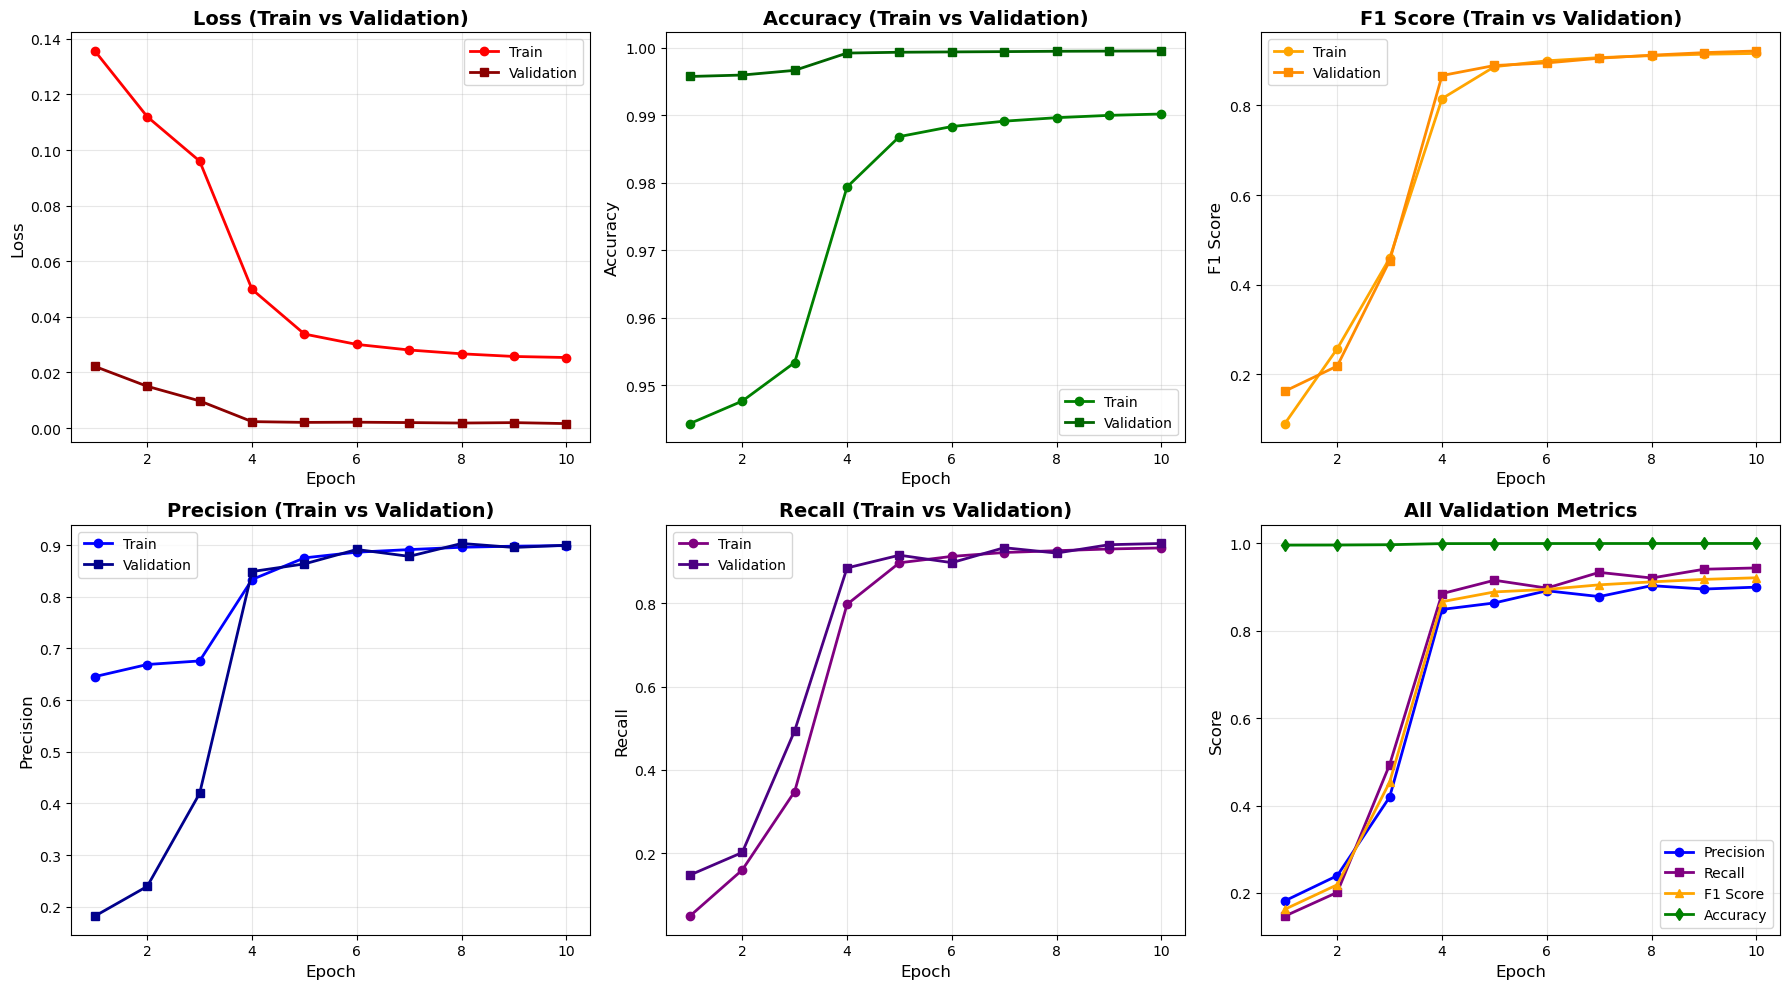

Plot saved to outputs/fourth_training/training_validation_metrics.png

=== Training Summary ===
Final Training Metrics:
  Loss: 0.0254
  Accuracy: 0.9902
  Precision: 0.8989
  Recall: 0.9329
  F1 Score: 0.9156

Final Validation Metrics:
  Loss: 0.0016
  Accuracy: 0.9995
  Precision: 0.8996
  Recall: 0.9436
  F1 Score: 0.9211

Best Scores:
  Best Training F1: 0.9156
  Best Validation F1: 0.9211


In [79]:
import matplotlib.pyplot as plt

# Plot training and validation metrics (6 separate graphs)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss plot
axes[0, 0].plot(epoch_numbers, train_losses, marker='o', linewidth=2, color='red', label='Train', markersize=6)
axes[0, 0].plot(epoch_numbers, val_losses, marker='s', linewidth=2, color='darkred', label='Validation', markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss (Train vs Validation)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='best')
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(epoch_numbers, train_accuracies, marker='o', linewidth=2, color='green', label='Train', markersize=6)
axes[0, 1].plot(epoch_numbers, val_accuracies, marker='s', linewidth=2, color='darkgreen', label='Validation', markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy (Train vs Validation)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10, loc='best')
axes[0, 1].grid(True, alpha=0.3)

# F1 Score plot
axes[0, 2].plot(epoch_numbers, train_f1_scores, marker='o', linewidth=2, color='orange', label='Train', markersize=6)
axes[0, 2].plot(epoch_numbers, val_f1_scores, marker='s', linewidth=2, color='darkorange', label='Validation', markersize=6)
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('F1 Score', fontsize=12)
axes[0, 2].set_title('F1 Score (Train vs Validation)', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10, loc='best')
axes[0, 2].grid(True, alpha=0.3)

# Precision plot
axes[1, 0].plot(epoch_numbers, train_precisions, marker='o', linewidth=2, color='blue', label='Train', markersize=6)
axes[1, 0].plot(epoch_numbers, val_precisions, marker='s', linewidth=2, color='darkblue', label='Validation', markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision (Train vs Validation)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10, loc='best')
axes[1, 0].grid(True, alpha=0.3)

# Recall plot
axes[1, 1].plot(epoch_numbers, train_recalls, marker='o', linewidth=2, color='purple', label='Train', markersize=6)
axes[1, 1].plot(epoch_numbers, val_recalls, marker='s', linewidth=2, color='indigo', label='Validation', markersize=6)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Recall (Train vs Validation)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10, loc='best')
axes[1, 1].grid(True, alpha=0.3)

# All metrics combined - Validation only (cleaner visualization)
axes[1, 2].plot(epoch_numbers, val_precisions, marker='o', linewidth=2, color='blue', label='Precision', markersize=6)
axes[1, 2].plot(epoch_numbers, val_recalls, marker='s', linewidth=2, color='purple', label='Recall', markersize=6)
axes[1, 2].plot(epoch_numbers, val_f1_scores, marker='^', linewidth=2, color='orange', label='F1 Score', markersize=6)
axes[1, 2].plot(epoch_numbers, val_accuracies, marker='d', linewidth=2, color='green', label='Accuracy', markersize=6)
axes[1, 2].set_xlabel('Epoch', fontsize=12)
axes[1, 2].set_ylabel('Score', fontsize=12)
axes[1, 2].set_title('All Validation Metrics', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=10, loc='best')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/{exp_name}/training_validation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Plot saved to {output_dir}/{exp_name}/training_validation_metrics.png')

# Print summary statistics
print('\n=== Training Summary ===')
print(f'Final Training Metrics:')
print(f'  Loss: {train_losses[-1]:.4f}')
print(f'  Accuracy: {train_accuracies[-1]:.4f}')
print(f'  Precision: {train_precisions[-1]:.4f}')
print(f'  Recall: {train_recalls[-1]:.4f}')
print(f'  F1 Score: {train_f1_scores[-1]:.4f}')

print(f'\nFinal Validation Metrics:')
print(f'  Loss: {val_losses[-1]:.4f}')
print(f'  Accuracy: {val_accuracies[-1]:.4f}')
print(f'  Precision: {val_precisions[-1]:.4f}')
print(f'  Recall: {val_recalls[-1]:.4f}')
print(f'  F1 Score: {val_f1_scores[-1]:.4f}')

print(f'\nBest Scores:')
print(f'  Best Training F1: {best_f1:.4f}')
print(f'  Best Validation F1: {best_val_f1:.4f}')

In [ ]:
# Load the best model for testing
best_model_path = f'{output_dir}/{exp_name}/model_best.pth'

if os.path.exists(best_model_path):
    print(f'Loading best model from {best_model_path}')
    checkpoint = torch.load(best_model_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model'])
    print(f'Best model loaded (Validation F1: {checkpoint.get("val_f1", "N/A")})')
else:
    print('No best model found, using current model')


Loading best model from outputs/fourth_training/model_best.pth
Best model loaded (Validation F1: 0.9210893964367004)


In [85]:

# Test evaluation function
def evaluate_test_model(model, data_loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on test data with detailed metrics.
    
    Returns:
        dict with test metrics and predictions
    """
    model.eval()
    
    all_outputs = []
    all_labels = []
    all_predictions = []
    total_loss = 0.0
    num_batches = 0
    
    print('\nEvaluating on test data...')
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Testing'):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            output = model(batch)
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            num_batches += 1
            
            # Get probabilities
            probs = torch.sigmoid(output).cpu().numpy().flatten()
            labels = batch['label'].cpu().numpy().flatten()
            preds = (probs >= threshold).astype(int)
            
            # Collect outputs, labels, and predictions
            all_outputs.extend(probs)
            all_labels.extend(labels)
            all_predictions.extend(preds)
    
    # Convert to numpy arrays
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    # Calculate metrics
    accuracy = (all_predictions == all_labels).mean()
    tp = ((all_predictions == 1) & (all_labels == 1)).sum()
    fp = ((all_predictions == 1) & (all_labels == 0)).sum()
    fn = ((all_predictions == 0) & (all_labels == 1)).sum()
    tn = ((all_predictions == 0) & (all_labels == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    avg_loss = total_loss / num_batches
    
    # Additional statistics
    positive_rate = (all_labels == 1).mean()
    predicted_positive_rate = (all_predictions == 1).mean()
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'positive_rate': positive_rate,
        'predicted_positive_rate': predicted_positive_rate,
        'probabilities': all_outputs,
        'labels': all_labels,
        'predictions': all_predictions
    }

# Evaluate on test data
test_metrics = evaluate_test_model(model, test_loader, criterion, device, threshold=0.5)

# Print test results
print('\n' + '='*60)
print('TEST SET EVALUATION RESULTS')
print('='*60)
print(f'Loss:      {test_metrics["loss"]:.4f}')
print(f'Accuracy:  {test_metrics["accuracy"]:.4f}')
print(f'Precision: {test_metrics["precision"]:.4f}')
print(f'Recall:    {test_metrics["recall"]:.4f}')
print(f'F1 Score:  {test_metrics["f1"]:.4f}')
print(f'\nConfusion Matrix:')
print(f'  TP: {test_metrics["tp"]:,}  |  FP: {test_metrics["fp"]:,}')
print(f'  FN: {test_metrics["fn"]:,}  |  TN: {test_metrics["tn"]:,}')
print(f'\nClass Distribution:')
print(f'  Actual Positive Rate: {test_metrics["positive_rate"]:.4f}')
print(f'  Predicted Positive Rate: {test_metrics["predicted_positive_rate"]:.4f}')
print('='*60)


Evaluating on test data...


Testing:   0%|          | 0/21219 [00:00<?, ?it/s]


TEST SET EVALUATION RESULTS
Loss:      0.0016
Accuracy:  0.9995
Precision: 0.8881
Recall:    0.9242
F1 Score:  0.9058

Confusion Matrix:
  TP: 28,396  |  FP: 3,577
  FN: 2,328  |  TN: 10,829,675

Class Distribution:
  Actual Positive Rate: 0.0028
  Predicted Positive Rate: 0.0029


## Test

In [89]:
# Test prediction between two specific nodes
import torch
import numpy as np

def predict_edge_between_nodes(model, node1, node2, class_dict, device, threshold=0.5):
    """
    Predict if there should be an edge between two nodes.
    
    Args:
        model: Trained MLP model
        node1: Dict with 'id', 'class_name', 'top', 'left', 'width', 'height'
        node2: Dict with 'id', 'class_name', 'top', 'left', 'width', 'height'
        class_dict: Dictionary mapping class names to IDs
        device: torch device
        threshold: Classification threshold (default 0.5)
    
    Returns:
        Dict with prediction results
    """
    model.eval()
    
    # Get bounding boxes [top, left, bottom, right]
    node1_bbox = torch.tensor([
        node1['top'],
        node1['left'],
        node1['top'] + node1['height'],
        node1['left'] + node1['width']
    ], dtype=torch.float32)
    
    node2_bbox = torch.tensor([
        node2['top'],
        node2['left'],
        node2['top'] + node2['height'],
        node2['left'] + node2['width']
    ], dtype=torch.float32)
    
    # Normalize bounding boxes (if your model expects normalized coords)
    # Assuming image size - adjust if needed
    image_height = 3000  # Typical MUSCIMA++ image height
    image_width = 3000   # Typical MUSCIMA++ image width
    
    reshape_weight = torch.tensor([2 / image_height, 2 / image_height,
                                   2 / image_height, 2 / image_height])
    reshape_bias = torch.tensor([-1, -image_width/image_height,
                                 -1, -image_width/image_height])
    
    node1_bbox_norm = node1_bbox * reshape_weight + reshape_bias
    node2_bbox_norm = node2_bbox * reshape_weight + reshape_bias
    
    # Get class IDs
    node1_class = torch.tensor(class_dict[node1['class_name']], dtype=torch.long)
    node2_class = torch.tensor(class_dict[node2['class_name']], dtype=torch.long)
    
    # Create batch (batch size = 1)
    batch = {
        'source_bbox': node1_bbox_norm.unsqueeze(0).to(device),
        'source_class': node1_class.unsqueeze(0).to(device),
        'target_bbox': node2_bbox_norm.unsqueeze(0).to(device),
        'target_class': node2_class.unsqueeze(0).to(device)
    }
    
    # Predict
    with torch.no_grad():
        output = model(batch)
        probability = torch.sigmoid(output).item()
        prediction = 1 if probability >= threshold else 0
    
    return {
        'probability': probability,
        'prediction': prediction,
        'has_edge': bool(prediction),
        'confidence': probability if prediction == 1 else (1 - probability)
    }


# Example: Test the two nodes you selected
node1 = {
    'id': 353,
    'class_name': 'stem',
    'top': 710,
    'left': 2732,
    'width': 14,
    'height': 152
}

node2 = {
    'id': 185,
    'class_name': 'noteheadFull',
    'top': 754,
    'left': 2725,
    'width': 23,
    'height': 22
}

In [ ]:
# Make prediction
result = predict_edge_between_nodes(model, node1, node2, class_dict, device, threshold=0.5)

print('\n' + '='*60)
print('EDGE PREDICTION BETWEEN TWO NODES')
print('='*60)
print(f'Node 1: ID={node1["id"]}, Class={node1["class_name"]}')
print(f'        Position: ({node1["left"]}, {node1["top"]}), Size: {node1["width"]}x{node1["height"]}')
print(f'\nNode 2: ID={node2["id"]}, Class={node2["class_name"]}')
print(f'        Position: ({node2["left"]}, {node2["top"]}), Size: {node2["width"]}x{node2["height"]}')
print(f'\n--- Prediction Results ---')
print(f'Probability: {result["probability"]:.4f}')
print(f'Prediction: {"EDGE EXISTS" if result["has_edge"] else "NO EDGE"}')
print(f'Confidence: {result["confidence"]:.4f}')
print('='*60)

# Calculate distance between nodes
distance = np.sqrt((node1['left'] - node2['left'])**2 + (node1['top'] - node2['top'])**2)
print(f'\nAdditional Info:')
print(f'Distance between nodes: {distance:.1f} pixels')
print(f'Node 1 → Node 2: {"✓" if node2["id"] in [17, 18, 19] else "✗"} (ground truth)')



EDGE PREDICTION BETWEEN TWO NODES
Node 1: ID=353, Class=stem
        Position: (2732, 710), Size: 14x152

Node 2: ID=185, Class=noteheadFull
        Position: (2725, 754), Size: 23x22

--- Prediction Results ---
Probability: 0.9944
Prediction: EDGE EXISTS
Confidence: 0.9944

Additional Info:
Distance between nodes: 44.6 pixels
Node 1 → Node 2: ✗ (ground truth)


In [92]:
model.state_dict()

OrderedDict([('class_embed.weight',
              tensor([[ 1.6851e-03, -2.9231e-02, -3.8743e-02,  ..., -1.7891e-02,  2.6972e-02, -1.5585e-02],
                      [ 1.5709e+00, -2.7491e-01, -1.1288e+00,  ..., -8.0154e-01, -1.3632e+00,  1.1789e+00],
                      [-4.0928e-02, -2.1412e-02,  8.5402e-02,  ...,  8.9882e-03, -2.0687e-02, -3.5794e-02],
                      ...,
                      [-3.3232e-01,  2.9916e-01, -2.3288e+00,  ..., -1.6809e+00, -1.5565e+00, -1.4332e+00],
                      [-1.2208e+00,  1.5130e+00,  6.2427e-01,  ...,  8.3411e-01,  1.5845e+00, -2.6866e-01],
                      [ 1.2179e+00,  1.0981e-01, -1.5682e+00,  ..., -1.0628e-01,  5.4898e-01, -2.1081e-01]])),
             ('MLP.0.weight',
              tensor([[ 1.4292e-01,  3.2838e+00, -1.1736e+00,  ..., -5.4195e-02, -3.9899e-02,  4.8967e-02],
                      [-1.6148e-01, -1.5386e-01,  1.8723e-01,  ..., -4.1963e-01, -8.4931e-01, -4.4154e-01],
                      [-5.5679e-01, -3.6

## 7. Save Final Model

In [93]:
# Save final model
final_checkpoint_path = f'{output_dir}/{exp_name}/model_final.pth'
checkpoint = {
    'epoch': NUM_EPOCHS,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(checkpoint, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to outputs/fourth_training/model_final.pth
